In [15]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FuncFormatter
import seaborn as sns
import pandas as pd
import sys
import math

import matplotlib
from matplotlib.colors import Normalize
import matplotlib.cm as cm
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
#from mpl_toolkits import mplot3d

# plt.rcParams.update({'font.size': 18})
# plt.rcParams["font.family"] = 'Times New Roman'
# matplotlib.rcParams['mathtext.fontset'] = 'custom'
# matplotlib.rcParams['mathtext.rm'] = 'Times New Roman'
# matplotlib.rcParams['mathtext.it'] = 'Times New Roman:italic'
# matplotlib.rcParams['mathtext.bf'] = 'Times New Roman:bold'

$$
\begin{align}

\frac{d}{dz}\Psi_{l,m,n}
& = iC_1 \left[ \Psi_{l-1,m,n} + \Psi_{l+1,m,n} \right]\\ 
& + iC_2 \left[ \Psi_{l,m-1,n} + \Psi_{l,m+1,n} \right] \\ 
& + iC_3 \left[ \Psi_{l,m,n-1} + \Psi_{l,m,n+1} \right]  \\
& + \sum_{p}^N  \delta_{m,p} \delta_{n,p} \delta_{l,p}  \gamma A_{p} e^{i\Delta \beta z}\\
& + i2\gamma  \Psi_{l,m,n}   \sum_{p}^N  |A_{p}|
\end{align}
$$

## Models and Definitions

### N_waveguides = 2 

In [16]:
# Main model as published in https://doi.org/10.1002/qute.202400409 
# Coupled differential equation for TOSPDC in two coupled nonlinear waveguide system (directional coupler)

def TOSPDC_nwg_2(z, Ez_Psi, C1, C2, C3, gamma, del_beta, del_phi):
    Ez = Ez_Psi[:n_wg]
    Psi = Ez_Psi[-n_wg**n_photon:]

    dEz_dz = [0j] * n_wg
    dPsi_dz = [0j] * (n_wg**n_photon)
    
    # dPsi_dz[0] = 1j * C * (Psi[1] + Psi[2] + Psi[4]) + 1j * Psi[0] * del_phi + gamma * Ez[0] * np.exp(1j * del_beta * z)
    dPsi_dz[0] = 1j * (C1 * Psi[2] + C2 * Psi[1] + C3 * Psi[4]) + 1j * Psi[0] * del_phi + gamma * Ez_Psi0[0] * np.exp(1j * del_beta * z)
    dPsi_dz[1] = 1j * (C1 * Psi[3] + C2 * Psi[0] + C3 * Psi[5]) + 1j * Psi[1] * del_phi
    dPsi_dz[2] = 1j * (C1 * Psi[0] + C2 * Psi[3] + C3 * Psi[6]) + 1j * Psi[2] * del_phi
    dPsi_dz[3] = 1j * (C1 * Psi[1] + C2 * Psi[2] + C3 * Psi[7]) + 1j * Psi[3] * del_phi
    dPsi_dz[4] = 1j * (C1 * Psi[6] + C2 * Psi[5] + C3 * Psi[0]) + 1j * Psi[4] * del_phi
    dPsi_dz[5] = 1j * (C1 * Psi[7] + C2 * Psi[4] + C3 * Psi[1]) + 1j * Psi[5] * del_phi
    dPsi_dz[6] = 1j * (C1 * Psi[4] + C2 * Psi[7] + C3 * Psi[2]) + 1j * Psi[6] * del_phi
    # dPsi_dz[7] = 1j * C * (Psi[3] + Psi[5] + Psi[6]) + 1j * Psi[7] * del_phi + gamma * Ez[1] * np.exp(1j * del_beta * z)
    dPsi_dz[7] = 1j * (C1 * Psi[5] + C2 * Psi[6] + C3 * Psi[3]) + 1j * Psi[7] * del_phi + gamma * Ez_Psi0[1] * np.exp(1j * del_beta * z)
    
    return np.concatenate((dEz_dz, dPsi_dz), axis=None)

In [17]:
Psi_index_n2 =  {0: '000', 1: '010',
                 2: '100', 3: '110',
                 4: '001', 5: '011',
                 6: '101', 7: '111'}

Psi_index_plot_n2 = [0,4,1,5,2,6,3,7] # Sequence change for plotting purposes

### N_waveguides = 2 with SPM

In [18]:
# Coupled differential equation for TOSPDC in two coupled nonlinear waveguide system (directional coupler) with Self Phase Modulation effects

def TOSPDC_nwg_2_SPM(z, Ez_Psi, C1, C2, C3, gamma, del_beta, del_phi):
    Ez = Ez_Psi[:n_wg]
    Psi = Ez_Psi[-n_wg**n_photon:]

    dEz_dz = [0j] * n_wg
    dPsi_dz = [0j] * (n_wg**n_photon)
    gamma_xpm = 1
    # dPsi_dz[0] = 1j * C * (Psi[1] + Psi[2] + Psi[4]) + 1j * Psi[0] * del_phi + gamma * Ez[0] * np.exp(1j * del_beta * z)
    dPsi_dz[0] = 1j * (C1 * Psi[2] + C2 * Psi[1] + C3 * Psi[4]) + 1j * Psi[0] * del_phi + 1j * Psi[0] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1]) + gamma * Ez_Psi0[0] * np.exp(1j * del_beta * z)
    dPsi_dz[1] = 1j * (C1 * Psi[3] + C2 * Psi[0] + C3 * Psi[5]) + 1j * Psi[1] * del_phi + 1j * Psi[1] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1])
    dPsi_dz[2] = 1j * (C1 * Psi[0] + C2 * Psi[3] + C3 * Psi[6]) + 1j * Psi[2] * del_phi + 1j * Psi[2] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1])
    dPsi_dz[3] = 1j * (C1 * Psi[1] + C2 * Psi[2] + C3 * Psi[7]) + 1j * Psi[3] * del_phi + 1j * Psi[3] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1])
    dPsi_dz[4] = 1j * (C1 * Psi[6] + C2 * Psi[5] + C3 * Psi[0]) + 1j * Psi[4] * del_phi + 1j * Psi[4] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1])
    dPsi_dz[5] = 1j * (C1 * Psi[7] + C2 * Psi[4] + C3 * Psi[1]) + 1j * Psi[5] * del_phi + 1j * Psi[5] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1])
    dPsi_dz[6] = 1j * (C1 * Psi[4] + C2 * Psi[7] + C3 * Psi[2]) + 1j * Psi[6] * del_phi + 1j * Psi[6] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1])
    # dPsi_dz[7] = 1j * C * (Psi[3] + Psi[5] + Psi[6]) + 1j * Psi[7] * del_phi + gamma * Ez[1] * np.exp(1j * del_beta * z)
    dPsi_dz[7] = 1j * (C1 * Psi[5] + C2 * Psi[6] + C3 * Psi[3]) + 1j * Psi[7] * del_phi + 1j * Psi[7] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1]) + gamma * Ez_Psi0[1] * np.exp(1j * del_beta * z)
    
    return np.concatenate((dEz_dz, dPsi_dz), axis=None)

### N_waveguides = 3

In [19]:
Psi_index_n3 =  {0: '000', 
              1: '010',
              2: '100', 
              3: '110',
              4: '001', 
              5: '011',
              6: '101', 
              7: '111',
              8: '002', 
              9: '012',
              10: '020', 
              11: '021',
              12: '022', 
              13: '102',
              14: '112', 
              15: '120',
              16: '121', 
              17: '122',
              18: '200', 19: '201',
              20: '202', 21: '210',
              22: '211', 23: '212',
              24: '220', 25: '221',
              26: '222'}

Psi_index_plot_n3 = [0,4,8,1,5,9,10,11,12,2,6,13,3,7,14,15,16,17,18,19,20,21,22,23,24,25,26] # Sequence change for plotting purposes

In [20]:
def TOSPDC_nwg_3(z, Ez_Psi, C1, C2, C3, gamma, del_beta, del_phi):

    n_wg = 3
    n_photon = 3

    Ez = Ez_Psi[:n_wg]
    Psi = Ez_Psi[-n_wg**n_photon:]

    dEz_dz = [0j] * n_wg
    dPsi_dz = [0j] * (n_wg**n_photon)
    gamma_xpm = 0
    dPsi_dz[0] = 1j * (C1 * Psi[2] + C2 * Psi[1] + C3 * Psi[4]) + 1j * Psi[0] * del_phi + 1j * Psi[0] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1]+ Ez_Psi0[2]) + gamma * Ez_Psi0[0] * np.exp(1j * del_beta * z)
    dPsi_dz[1] = 1j * (C1 * Psi[3] + C2 * Psi[0] + C2 * Psi[10] + C3 * Psi[5]) + 1j * Psi[1] * del_phi + 1j * Psi[1] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1]+ Ez_Psi0[2])
    dPsi_dz[2] = 1j * (C1 * Psi[0] + C1 * Psi[18] + C2 * Psi[3] + C3 * Psi[6]) + 1j * Psi[2] * del_phi + 1j * Psi[2] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1]+ Ez_Psi0[2])
    dPsi_dz[3] = 1j * (C1 * Psi[1] + C1 * Psi[21] + C2 * Psi[2] + C2 * Psi[15] + C3 * Psi[7]) + 1j * Psi[3] * del_phi + 1j * Psi[3] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1]+ Ez_Psi0[2])
    dPsi_dz[4] = 1j * (C1 * Psi[6] + C2 * Psi[5] + C3 * Psi[0] + C3 * Psi[8]) + 1j * Psi[4] * del_phi + 1j * Psi[4] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1]+ Ez_Psi0[2])
    dPsi_dz[5] = 1j * (C1 * Psi[7] + C2 * Psi[4] + C2 * Psi[11] + C3 * Psi[1] + C3 * Psi[9]) + 1j * Psi[5] * del_phi + 1j * Psi[5] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1]+ Ez_Psi0[2])
    dPsi_dz[6] = 1j * (C1 * Psi[4] + C1 * Psi[19] + C2 * Psi[7] + C3 * Psi[2] + C3 * Psi[13]) + 1j * Psi[6] * del_phi + 1j * Psi[6] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1]+ Ez_Psi0[2])
    dPsi_dz[7] = 1j * (C1 * Psi[5] + C1 * Psi[22] + C2 * Psi[6] + C2 * Psi[16] + C3 * Psi[3] + C3 * Psi[14]) + 1j * Psi[7] * del_phi + 1j * Psi[7] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1]+ Ez_Psi0[2]) + gamma * Ez_Psi0[1] * np.exp(1j * del_beta * z)
    dPsi_dz[8] = 1j * (C1 * Psi[13] + C2 * Psi[9] + C3 * Psi[4]) + 1j * Psi[8] * del_phi + 1j * Psi[8] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1]+ Ez_Psi0[2])
    dPsi_dz[9] = 1j * (C1 * Psi[14] + C2 * Psi[8] + C2 * Psi[12] + C3 * Psi[5]) + 1j * Psi[9] * del_phi + 1j * Psi[9] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1]+ Ez_Psi0[2])
    dPsi_dz[10] = 1j * (C1 * Psi[15] + C2 * Psi[1] + C3 * Psi[11]) + 1j * Psi[10] * del_phi + 1j * Psi[10] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1]+ Ez_Psi0[2])
    dPsi_dz[11] = 1j * (C1 * Psi[16] + C2 * Psi[5] + C3 * Psi[12] + C3 * Psi[10]) + 1j * Psi[11] * del_phi + 1j * Psi[11] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1]+ Ez_Psi0[2])
    dPsi_dz[12] = 1j * (C1 * Psi[17] + C2 * Psi[9] + C3 * Psi[11]) + 1j * Psi[12] * del_phi + 1j * Psi[12] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1]+ Ez_Psi0[2])
    dPsi_dz[13] = 1j * (C1 * Psi[8] + C1 * Psi[20] + C2 * Psi[14] + C3 * Psi[6]) + 1j * Psi[13] * del_phi + 1j * Psi[13] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1]+ Ez_Psi0[2])
    dPsi_dz[14] = 1j * (C1 * Psi[23] + C1 * Psi[9] + C2 * Psi[17] + C2 * Psi[13] + C3 * Psi[7]) + 1j * Psi[14] * del_phi + 1j * Psi[14] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1]+ Ez_Psi0[2])
    dPsi_dz[15] = 1j * (C1 * Psi[10] + C1 * Psi[24] + C2 * Psi[3] + C3 * Psi[16]) + 1j * Psi[15] * del_phi + 1j * Psi[15] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1]+ Ez_Psi0[2])
    dPsi_dz[16] = 1j * (C1 * Psi[11] + C1 * Psi[25] + C2 * Psi[7] + C3 * Psi[15] + C3 * Psi[17]) + 1j * Psi[16] * del_phi + 1j * Psi[16] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1]+ Ez_Psi0[2])
    dPsi_dz[17] = 1j * (C1 * Psi[12] + C1 * Psi[26] + C2 * Psi[14] + C3 * Psi[16]) + 1j * Psi[17] * del_phi + 1j * Psi[17] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1]+ Ez_Psi0[2])
    dPsi_dz[18] = 1j * (C1 * Psi[2] + C2 * Psi[21] + C3 * Psi[19]) + 1j * Psi[18] * del_phi + 1j * Psi[18] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1]+ Ez_Psi0[2])
    dPsi_dz[19] = 1j * (C1 * Psi[6] + C2 * Psi[22] + C3 * Psi[18] + C3 * Psi[20]) + 1j * Psi[19] * del_phi + 1j * Psi[19] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1]+ Ez_Psi0[2])
    dPsi_dz[20] = 1j * (C1 * Psi[13] + C2 * Psi[23] + C3 * Psi[19]) + 1j * Psi[20] * del_phi + 1j * Psi[20] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1]+ Ez_Psi0[2])
    dPsi_dz[21] = 1j * (C1 * Psi[3] + C2 * Psi[24] + C2 * Psi[18] + C3 * Psi[22]) + 1j * Psi[21] * del_phi + 1j * Psi[21] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1]+ Ez_Psi0[2])
    dPsi_dz[22] = 1j * (C1 * Psi[7] + C2 * Psi[25] + C2 * Psi[19] + C3 * Psi[21] + C3 * Psi[23]) + 1j * Psi[22] * del_phi + 1j * Psi[22] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1]+ Ez_Psi0[2])
    dPsi_dz[23] = 1j * (C1 * Psi[14] + C2 * Psi[26] + C2 * Psi[20] + C3 * Psi[22]) + 1j * Psi[23] * del_phi + 1j * Psi[23] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1]+ Ez_Psi0[2])
    dPsi_dz[24] = 1j * (C1 * Psi[15] + C2 * Psi[21] + C3 * Psi[25]) + 1j * Psi[24] * del_phi + 1j * Psi[24] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1]+ Ez_Psi0[2])
    dPsi_dz[25] = 1j * (C1 * Psi[16] + C2 * Psi[22] + C3 * Psi[26] + C3 * Psi[24]) + 1j * Psi[25] * del_phi + 1j * Psi[25] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1]+ Ez_Psi0[2])
    dPsi_dz[26] = 1j * (C1 * Psi[17] + C2 * Psi[23] + C3 * Psi[25]) + 1j * Psi[26] * del_phi + 1j * Psi[26] * 2 * gamma_xpm * (Ez_Psi0[0] + Ez_Psi0[1]+ Ez_Psi0[2]) + gamma * Ez_Psi0[2] * np.exp(1j * del_beta * z)
    return np.concatenate((dEz_dz, dPsi_dz), axis=None)

### N_waveguides = N

In [21]:
def TOSPDC_nwg_N(z, Ez_Psi, C1, C2, C3, gamma, del_beta, del_phi):
    gamma_xpm = 0
    #C1=1
    #C2=1
    #C3=1
    wg_num = 3
    n_photon = 3
    Psi_index = []
    #del_phi = 1
    #gamma=1
    #z=1
    #del_beta=1
    sep=''
    #print(Ez_Psi)

    Ez = Ez_Psi[:wg_num]
    Psi = Ez_Psi[-wg_num**n_photon:]
    #Ez = [1 + 0j] *wg_num                  # Complex amplitude of pump at waveguide 1 and 2
    #Psi = [0] * (wg_num**n_photon)           # Initial wavefunction set to zero
    #Ez_Psi = Ez + Psi
    dEz_dz = [0j] * wg_num
    dPsi_dz = [0j] * (wg_num**n_photon)
    
    for l in range(0,wg_num):
        for m in range(0,wg_num):
            for n in range(0,wg_num):
                entry = str(l)+str(m)+str(n)
                Psi_index.append(entry)
    #print(Psi_index)
    
    Waveguidepumpbracket = 0
    for pumpnum in range(0,wg_num):
        Waveguidepumpbracket = Waveguidepumpbracket + Ez_Psi[pumpnum]
    #print(dPsi_dz)    
    for indexnum in range(0,len(dPsi_dz)):
        Psi_sbscrpt = Psi_index[indexnum]
        #print(Psi_sbscrpt)
        C1valuebelow = list(Psi_sbscrpt)
        C1valuebelow[0] = str(int(C1valuebelow[0])-1)
        C1valuebelow = sep.join(C1valuebelow)
        if C1valuebelow in Psi_index:
            C1valuebelowindex = Psi_index.index(C1valuebelow)
            C1valuebelowentry = Psi[C1valuebelowindex]
        else:
            C1valuebelowentry = 0

        C1valueabove = list(Psi_sbscrpt)
        C1valueabove[0] = str(int(C1valueabove[0])+1)
        C1valueabove = sep.join(C1valueabove)
        #print(type(C1valueabove))
        if C1valueabove in Psi_index:
            C1valueaboveindex = Psi_index.index(C1valueabove)
            C1valueaboveentry = Psi[C1valueaboveindex]
            #print(C1valueaboveentry)
        else:
            C1valueaboveentry = 0

        C2valuebelow = list(Psi_sbscrpt)
        C2valuebelow[1] = str(int(C2valuebelow[1])-1)
        C2valuebelow = sep.join(C2valuebelow)
        if C2valuebelow in Psi_index:
            C2valuebelowindex = Psi_index.index(C2valuebelow)
            C2valuebelowentry = Psi[C2valuebelowindex]
        else:
            C2valuebelowentry = 0
        C2valueabove = list(Psi_sbscrpt)
        C2valueabove[1] = str(int(C2valueabove[1])+1)
        C2valueabove = sep.join(C2valueabove)
        if C2valueabove in Psi_index:
            C2valueaboveindex = Psi_index.index(C2valueabove)
            C2valueaboveentry = Psi[C2valueaboveindex]
        else:
            C2valueaboveentry = 0
        C3valuebelow = list(Psi_sbscrpt)
        C3valuebelow[2] = str(int(C3valuebelow[2])-1)
        C3valuebelow = sep.join(C3valuebelow)
        if C3valuebelow in Psi_index:
            C3valuebelowindex = Psi_index.index(C3valuebelow)
            C3valuebelowentry = Psi[C3valuebelowindex]
        else:
            C3valuebelowentry = 0
        C3valueabove = list(Psi_sbscrpt)
        C3valueabove[2] = str(int(C3valueabove[2])+1)
        C3valueabove = sep.join(C3valueabove)
        if C3valueabove in Psi_index:
            C3valueaboveindex = Psi_index.index(C3valueabove)
            C3valueaboveentry = Psi[C3valueaboveindex]
        else:
            C3valueaboveentry = 0

        samewaveguideterm = 0
        samewaveguidels = list(set(list(Psi_sbscrpt)))
        #print(samewaveguidels)

        if len(samewaveguidels) == 1:
            samewaveguideterm = gamma * Ez_Psi[int(samewaveguidels[0])] * np.exp(1j * del_beta * z)
            #print(Ez_Psi0[int(samewaveguidels[0])])
        Finalterm = 1j * Psi[indexnum] * 2 * gamma_xpm * Waveguidepumpbracket + samewaveguideterm
        dPsi_dz[indexnum] = 1j * ( C1 * (C1valuebelowentry + C1valueaboveentry) + C2 * (C2valuebelowentry + C2valueaboveentry) + C3 * (C3valuebelowentry + C3valueaboveentry)) + 1j * Psi[indexnum] * del_phi + Finalterm
        #print(dPsi_dz[indexnum])

        #dPsi_dz[indexnum] =
    return np.concatenate((dEz_dz, dPsi_dz), axis=None)


In [22]:

wg_num = 3
n_photon = 3
Psi_index = []
for l in range(0,wg_num):
    for m in range(0,wg_num):
        for n in range(0,wg_num):
            entry = str(l)+str(m)+str(n)
            Psi_index.append(entry)

### Data Analysis Scripts

In [23]:
# Read dataframe with string-encoded complex numbers and convert back to numeric complex.
def read_csv2(filename):
    df = pd.read_csv(filename,index_col=0)
    complex_headers=['Ez1','Ez2','Psi0', 'Psi1', 'Psi2', 'Psi3', 'Psi4', 'Psi5', 'Psi6', 'Psi7']
    complex_df = df[complex_headers]
    df[complex_headers]=pd.DataFrame(np.array(complex_df,dtype=complex), columns=complex_headers)
    main_df = df
    return main_df

In [24]:
# Plot individual wavefunctions
def plot_each_wfcn(main_df,Psi_index,Psi_index_plot):
    delBetas = list(set(main_df['delBeta']))
    delBetas.sort()

    for k in Psi_index_plot:
        array_2d = []
        for delBeta in delBetas:
            subdf = main_df[main_df['delBeta'] == delBeta]
            array_2d.append(np.square(np.abs(subdf['Psi%s' %(str(k))])))
        #    plt.plot(np.square(np.abs(subdf['Psi5'])))

        plt.figure(figsize=(3,3))
        plt.title(r'$|\Psi_{%s}|^2$' %(Psi_index[k]))
        #plt.axvline(3.41, color='r')
        plt.imshow(np.transpose(array_2d),extent=(min(delBetas), max(delBetas),0,max_z) ,origin='lower',aspect='auto')
        plt.xticks([-2*np.pi,-np.pi,0,np.pi,2*np.pi], ['-2π','-π','0','π','2π'])
        plt.yticks([0,np.pi,2*np.pi],[0,'π','2π'])
        plt.colorbar(fraction=0.046, pad=0.04,label='Intensity')    
        plt.xlabel(r'$\Delta \beta$')
        plt.ylabel('z')
        plt.show()

In [25]:
# Plot all wavefunctions together - Amplitude
def plot_all_wfcn(main_df,lines,Psi_index,Psi_index_plot):
    delBetas = list(set(main_df['delBeta']))
    delBetas.sort()
    delBetas_pi = [x/np.pi for x in delBetas]

    z_vals = list(set(main_df['z']))
    z_vals.sort()

    #plt.figure(figsize=(10,6))
    # sns.set(font_scale=1.0,style='white', palette='deep',font='Arial',rc = {'figure.figsize':(8,5)})
    n_plots = len(Psi_index_plot)
    n_cols = 4
    n_rows = math.ceil(n_plots/n_cols)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(n_cols*2.5,n_rows*2.5),layout='tight')
    loop_n=0
    for k,ax in zip(Psi_index_plot,axes.flat):                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
        array_2d = []
        loop_n=loop_n+1
        for delBeta in delBetas:
            subdf = main_df[main_df['delBeta'] == delBeta]
            array_2d.append(np.square(np.abs(subdf['Psi%s' %(str(k))])))
        #    plt.plot(np.square(np.abs(subdf['Psi5'])))
        # plt.subplot(2,4,loop_n)
        ax.set_title(r'$|\Psi_{%s}|^2$' %(str(Psi_index[k])))
        #im = ax.imshow(np.transpose(array_2d),extent=(min(delBetas), max(delBetas),0,max_z) ,origin='lower',aspect=1,cmap='YlGnBu')#,aspect='auto')
        im = ax.pcolormesh(delBetas_pi,z_vals,np.transpose(array_2d))
        #ax.axvline(4.28,linestyle='--',color='white')
        if len(lines)> 0:
            for line in lines:
                # ax.axvline(line,linestyle=':',color='white')
                ax.axvline(line,linestyle=':',color='m')
        #ax.set_xticks([-2*np.pi,-np.pi,0,np.pi,2*np.pi,3*np.pi], ['-2π','-π','0','π','2π','3π'])
        #ax.set_yticks([0,np.pi,2*np.pi,3*np.pi,4*np.pi,5*np.pi,6*np.pi],[0,'π','2π','3π','4π','5π','6π'])
        
        ax.set_xlabel(r'$\Delta \beta^{0} (\pi)$')
        #ax.set_ylabel('z')
        #im.colorbar(fraction=0.046, pad=0.04,label='Intensity')     
        plt.colorbar(im,ax=ax,shrink=1.0)
    #plt.savefig('AWtesting_XPMC112fig')
    #plt.savefig('AWtesting_noXPMC111figtestfurtherz.pdf',dpi=200,bbox_inches='tight')
    plt.show()


In [26]:
# Plot all wavefunctions together - Phase
def plot_all_wfcn_phase(main_df,lines,Psi_index,Psi_index_plot):
    delBetas = list(set(main_df['delBeta']))
    delBetas.sort()
    delBetas_pi = [x/np.pi for x in delBetas]

    z_vals = list(set(main_df['z']))
    z_vals.sort()

    #plt.figure(figsize=(10,6))
    # sns.set(font_scale=1.0,style='white', palette='deep',font='Arial',rc = {'figure.figsize':(8,5)})
    n_plots = len(Psi_index_plot)
    n_cols = 4
    n_rows = math.ceil(n_plots/n_cols)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(n_cols*2.5,n_rows*2.5),layout='tight')
    loop_n=0
    for k,ax in zip(Psi_index_plot,axes.flat):                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
        array_2d = []
        loop_n=loop_n+1
        for delBeta in delBetas:
            subdf = main_df[main_df['delBeta'] == delBeta]
            array_2d.append(np.angle(subdf['Psi%s' %(str(k))]))
        #    plt.plot(np.square(np.abs(subdf['Psi5'])))
        # plt.subplot(2,4,loop_n)
        ax.set_title(r'$|\Psi_{%s}|^2$' %(str(Psi_index[k])))
        #im = ax.imshow(np.transpose(array_2d),extent=(min(delBetas), max(delBetas),0,max_z) ,origin='lower',aspect=1,cmap='YlGnBu')#,aspect='auto')
        im = ax.pcolormesh(delBetas_pi,z_vals,np.transpose(array_2d))
        #ax.axvline(4.28,linestyle='--',color='white')
        if len(lines)> 0:
            for line in lines:
                ax.axvline(line,linestyle=':',color='white')
                #ax.axvline(line,linestyle=':',color='m')
        #ax.set_xticks([-2*np.pi,-np.pi,0,np.pi,2*np.pi,3*np.pi], ['-2π','-π','0','π','2π','3π'])
        #ax.set_yticks([0,np.pi,2*np.pi,3*np.pi,4*np.pi,5*np.pi,6*np.pi],[0,'π','2π','3π','4π','5π','6π'])
        
        ax.set_xlabel(r'$\Delta \beta^{0} (\pi)$')
        #ax.set_ylabel('z')
        #im.colorbar(fraction=0.046, pad=0.04,label='Intensity')     
        plt.colorbar(im,ax=ax,shrink=1.0)
    #plt.savefig('AWtesting_XPMC112fig')
    #plt.savefig('AWtesting_noXPMC111figtestfurtherz.pdf',dpi=200,bbox_inches='tight')
    plt.show()


In [27]:
# Plot all wavefunctions togeteher for publication

def plot_wfcns(main_df,lines=[]):
    delBetas = list(set(main_df['delBeta']))
    delBetas.sort()

    Psi_index_condensed = [0,2,1,4]
    titles=[r'$|\Psi_{000}|^2=|\Psi_{111}|^2$',
           r'$|\Psi_{100}|^2=|\Psi_{011}|^2$',
           r'$|\Psi_{010}|^2=|\Psi_{101}|^2$',
           r'$|\Psi_{001}|^2=|\Psi_{110}|^2$',]

    # sns.set(font_scale=1.0,style='white', palette='deep',font='Arial',rc = {'figure.figsize':(11,3)})
    fig, axes = plt.subplots(nrows=4, ncols=1,figsize=(4,10),sharex=False,layout='constrained')
    max_value = max((np.abs(main_df[['Psi0', 'Psi1', 'Psi2', 'Psi4']])**2).max())
    normalizer = Normalize(0, 1)
    imx = cm.ScalarMappable(norm=normalizer)

    for loop,k,ax in zip(range(len(Psi_index_condensed)),Psi_index_condensed,axes.flat):
        array_2d = []
        for delBeta in delBetas:
            subdf = main_df[main_df['delBeta'] == delBeta]
            array_2d.append(np.square(np.abs(subdf['Psi%s' %(str(k))]))/max_value)

        #ax.set_title(titles[loop])

        im = ax.imshow(np.transpose(array_2d),extent=(min(delBetas), max(delBetas),0,max_z) ,origin='lower',aspect=2, norm=normalizer,cmap='viridis')
        if len(lines) > 0:
            for line in lines:
                if loop in [0,3]:
                    ax.axvline(line,linestyle=':',color='white',alpha=0.7,linewidth=3)
        #ax.set_xticks([-2*np.pi,-np.pi,0,np.pi,2*np.pi], ['-2π','-π','0','π','2π'],fontsize=18)
        #ax.set_xticks([-5,-3,0,np.pi,2*np.pi], ['-2π','-π','0','π','2π'],fontsize=18)
        ax.set_yticks([0,np.pi,2*np.pi],[0,'π','2π'])
        #ax.set_xlabel(r'$\Delta \beta$')
        #ax.set_ylabel(titles[loop])
        cbar = plt.colorbar(im,ax=ax,shrink=1,label=titles[loop])
        cbar.set_ticks([0,0.5,1])
        #cbar.set_ticklabels([mn,md,mx])
        #im.colorbar(fraction=0.046, pad=0.04,label='Intensity')     
    #fig.subplots_adjust(hspace=None)
    #cbar = fig.colorbar(imx, ax=axes.ravel().tolist(), shrink=0.7)
    #cbar.set_ticks([0,5,10])
    #fig.supxlabel(r'Phase Difference $\Delta \beta$')
    fig.supylabel(r'Propagation Distance, $z$')
    # plt.savefig('240702 - SPDC-Waveguide-Data/240807_z_prop_C1=C2=1_C3=1_delBsweep_zsweep.jpg',dpi=300)
    plt.show()

In [28]:
from itertools import product

def generate_states(N_waveguides, N_photons):
    waveguides = list(range(1,N_waveguides+1))

    # Generate all possible combinations
    combinations = list(product(waveguides, repeat=N_photons))

    # Join each combination into a single number as a string
    result = [''.join(map(str, combo)) for combo in combinations]
    
    return result


def calc_resonances(N_waveguides,N_photons,C_vals):
    states = generate_states(N_waveguides,N_photons)

    resonances = []
    for state in states:
        N = len(state)
        if len(C_vals)==N:
            resonances.append(round(sum([2*C_vals[index]*np.cos(np.pi*int(state[index])/(N_waveguides+1)) for index in range(N)]),5))
        else: 
            print('len(C_vals) is not equal len(N_photons)')
    results = pd.DataFrame(list(zip(states,resonances)),columns=['State','Resonance'])
    return(results)

## Workspace 1 - N=2, Z and Beta dependence

### Solver. N=2. Fixed C1=C2 and C3 over z and $\Delta \beta$

In [ ]:
n_photon = 3
n_wg = 2

C1 = 1
C2 = 1
C3 = 1

max_z = 2*np.pi
zs=np.linspace(0,max_z,200)

gamma = 1
delBeta = 0
delPhi = 0

Ez0 = [1 + 0j] *n_wg                 # Complex amplitude of pump at waveguide 1 and 2
Psi0 = [0] * (n_wg**n_photon)        # Initial three-photon wavefunction set to zero
Ez_Psi0 = Ez0 + Psi0

delBeta_range = np.arange(-2*3.14,3*3.14+0.2,0.2)
#delBeta_range = [0.0, 1.41421, 2.82843, 4.24264, -4.24264, -2.82843, -1.41421]

df_list= []
#for delBeta in delBeta_range:
for delBeta in delBeta_range:
    Ez_Psi = solve_ivp(TOSPDC_nwg_2
                        , [0, max_z]
                        , Ez_Psi0
                        # , max_step=max_step_z  # comment out if the "t_eval=" is specified
                        , t_eval=zs
                        , dense_output=True
                        , args=(C1, C2, C3, gamma, delBeta, delPhi)) 

    columns = []
    columns2 = []     
    for i in range(0,n_wg):
        column_name = 'Ez' + str(i)
        columns.append(column_name)
    for i in range(0, n_wg**n_photon):
        column_name = 'Psi' + str(i)
        columns.append(column_name)
        columns2.append(column_name)
        
    data = pd.DataFrame(Ez_Psi.y.transpose(),columns=columns)
    data['z']=Ez_Psi.t
    data.insert(0, 'z', data.pop('z')) 
    
    Psi = data[columns2]
    Psi = np.array(Psi)
    norm_fac = np.sqrt(np.sum(np.abs(Psi)**2))

    # Include metadata
    data['NormFac'] = norm_fac
    data['C1'] = C1
    data['C2'] = C2
    data['C3'] = C3
    data['Gamma'] = gamma
    data['delBeta'] = round(delBeta, 3)
    data['delPhi'] = delPhi
    df_list.append(data)

main_df = pd.concat(df_list,ignore_index=True)

# Externally save file if working on large and multiple dataframes
# main_df.to_csv('250409 - Data/250409_solution_C1=C2=C3=1_delBsweep_zsweep.csv')


### Plot results

In [31]:
Psi_index_n2 =  {0: '000', 1: '010',
                 2: '100', 3: '110',
                 4: '001', 5: '011',
                 6: '101', 7: '111'}

Psi_index_plot_n2 = [0,4,1,5,2,6,3,7] # Sequence change for plotting purposes

In [ ]:
Psi_index_n3 = []
wg_num = 3
for l in range(0,wg_num):
        for m in range(0,wg_num):
            for n in range(0,wg_num):
                entry = str(l)+str(m)+str(n)
                Psi_index.append(entry)
    #print(Psi_index)
Psi_index_plot_n3 = list(range(0, wg_num**n_photon))
#plot_each_wfcn(main_df)


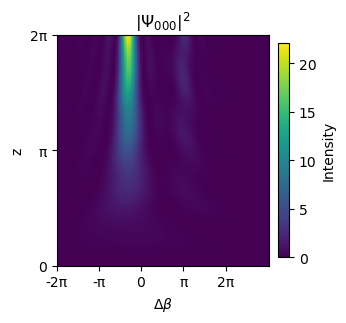

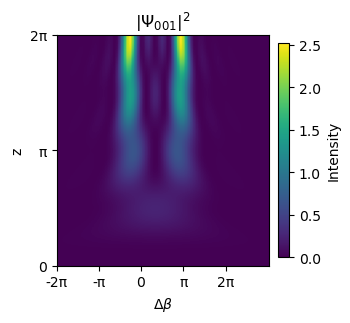

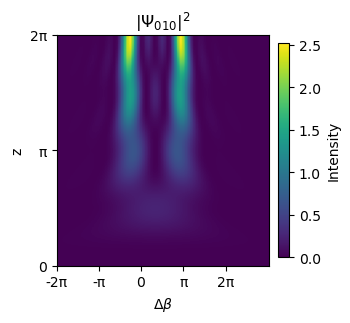

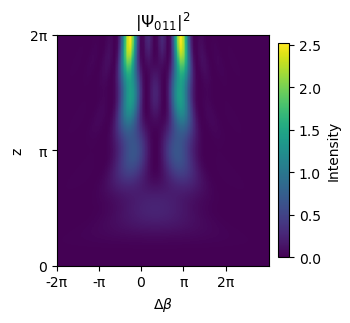

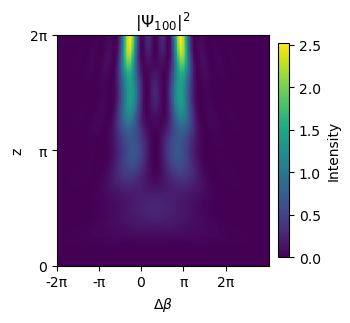

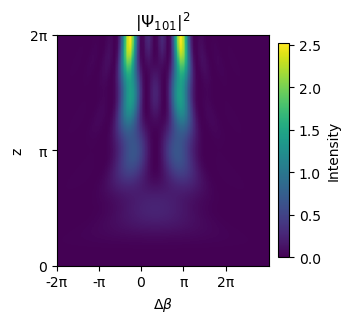

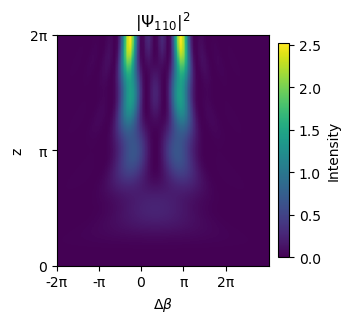

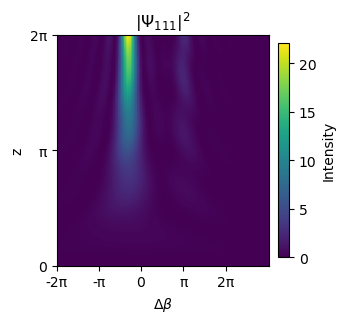

In [35]:
plot_each_wfcn(main_df,Psi_index_n2,Psi_index_plot_n2)

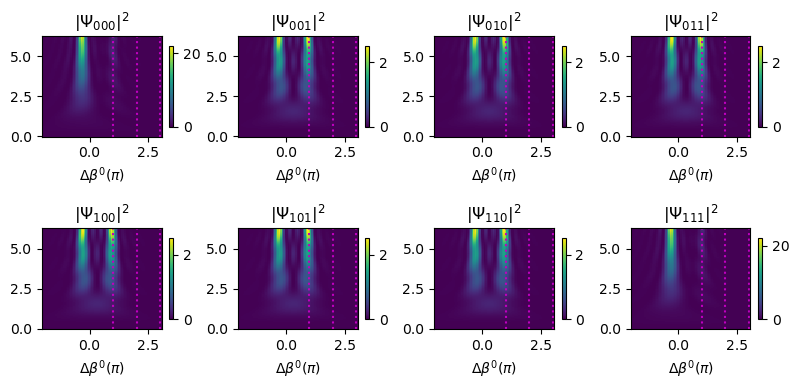

In [71]:
plot_all_wfcn(main_df,[1,2,3],Psi_index_n2,Psi_index_plot_n2)

### Plot published results

In [93]:
z_prop_C3_1 = read_csv2('240702 - Data/240715_solution_C1=C2=1_C3=1_delBsweep_zsweep.csv')
z_prop_C3_2 = read_csv2('240702 - Data/240715_solution_C1=C2=1_C3=2_delBsweep_zsweep.csv')
z_prop_C3_3 = read_csv2('240702 - Data/240718_solution_C1=C2=0.1_C3=0.1_delBsweep_zsweep.csv')

In [100]:
Psi_index_n2 =  {0: '000', 1: '010',
                 2: '100', 3: '110',
                 4: '001', 5: '011',
                 6: '101', 7: '111'}

Psi_index_plot_n2 = [0,4,1,5,2,6,3,7] # Sequence change for plotting purposes

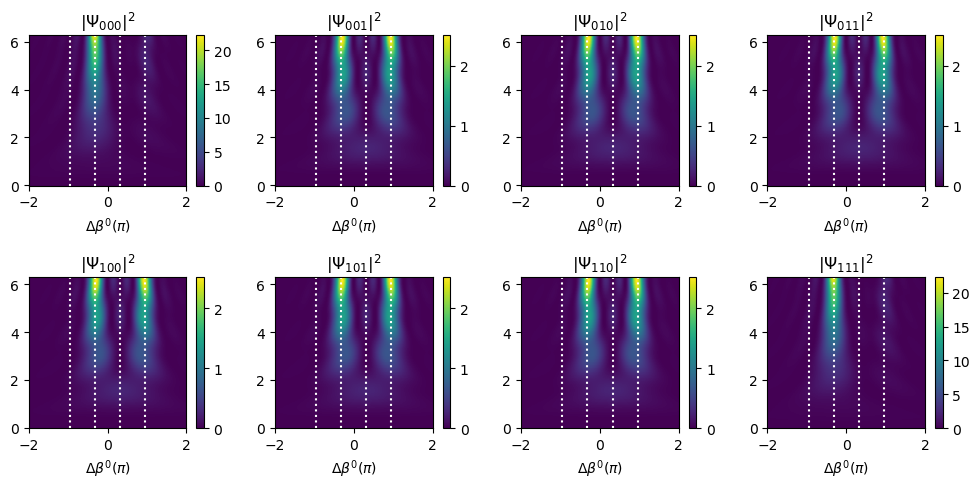

In [ ]:
# Plot Result 1: C1=C2=C3=1

results_df = calc_resonances(N_waveguides=2,N_photons=3,C_vals=[1,1,1])
resonances = np.array(list(set(results_df['Resonance'])))/np.pi
plot_all_wfcn(z_prop_C3_1,resonances,Psi_index_n2,Psi_index_plot_n2)


In [111]:
results_df = calc_resonances(N_waveguides=2,N_photons=3,C_vals=[1,1,2])
resonances = np.array(list(set(results_df['Resonance'])))
resonances

array([ 0.,  2.,  4., -4., -2.])

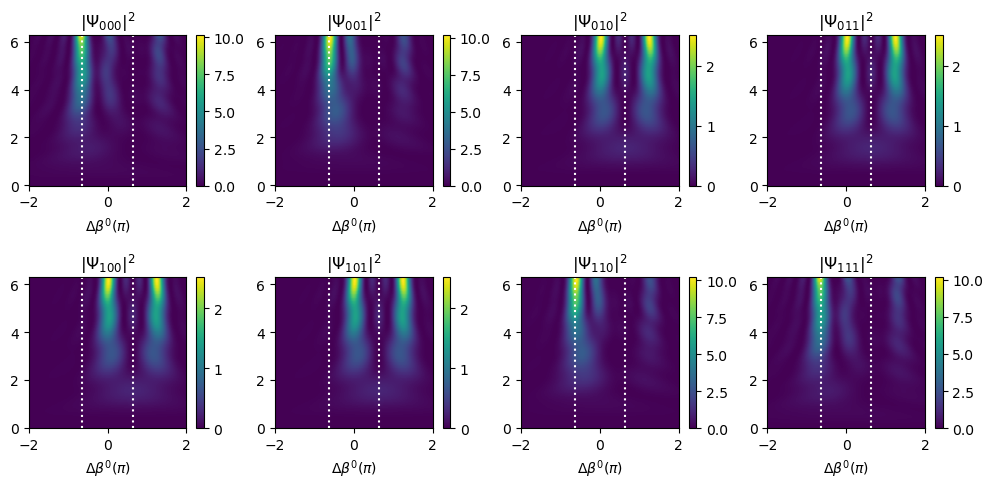

In [112]:
# Plot Result 2: C1=C2=1, C3=2

results_df = calc_resonances(N_waveguides=2,N_photons=3,C_vals=[1,1,2])
#resonances = np.array(list(set(results_df['Resonance'])))/np.pi
resonances = [-2/np.pi,2/np.pi]
plot_all_wfcn(z_prop_C3_2,resonances,Psi_index_n2,Psi_index_plot_n2)


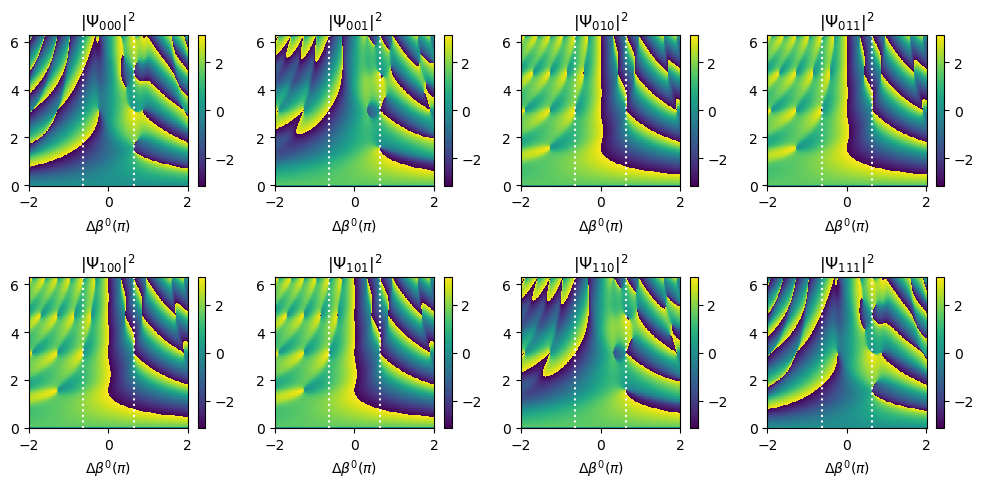

In [113]:
# Plot Result 2: C1=C2=1, C3=2 (Phases)

results_df = calc_resonances(N_waveguides=2,N_photons=3,C_vals=[1,1,2])
#resonances = np.array(list(set(results_df['Resonance'])))/np.pi
resonances = [-2/np.pi,2/np.pi]
plot_all_wfcn_phase(z_prop_C3_2,resonances,Psi_index_n2,Psi_index_plot_n2)


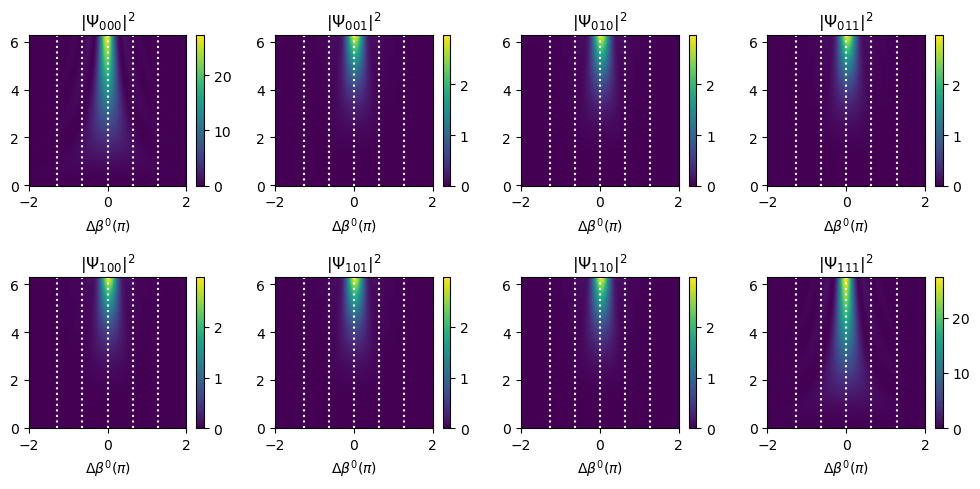

In [99]:
# Plot Result 3: C1=C2=1, C3=0.1

results_df = calc_resonances(N_waveguides=2,N_photons=3,C_vals=[1,1,2])
resonances = np.array(list(set(results_df['Resonance'])))/np.pi
plot_all_wfcn(z_prop_C3_3,resonances,Psi_index_n2,Psi_index_plot_n2)


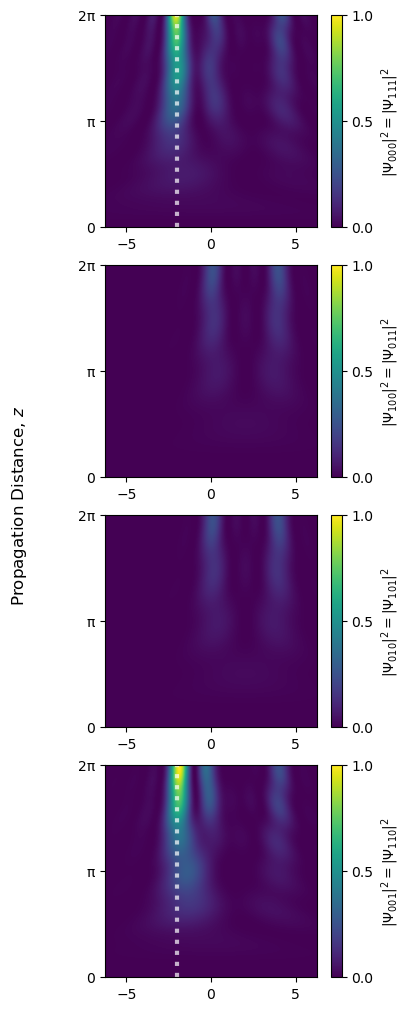

In [117]:
# Plot all wavefunctions together for publication

plot_wfcns(z_prop_C3_2,[-2])

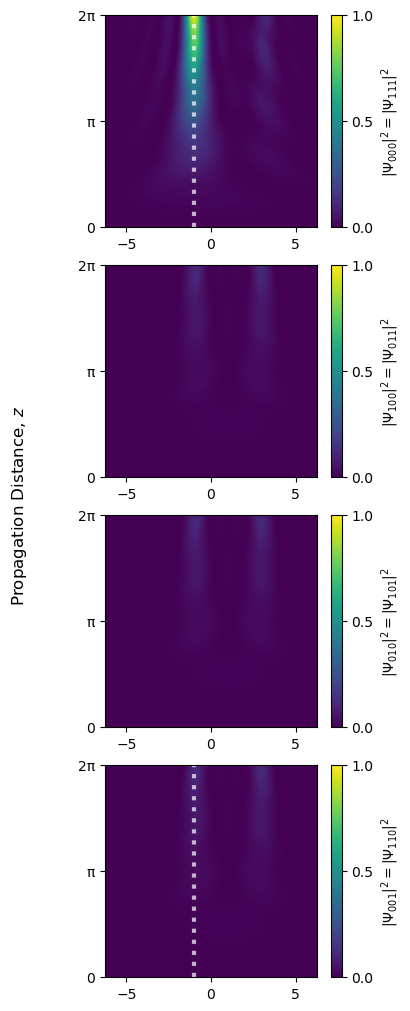

In [118]:
plot_wfcns(z_prop_C3_1,lines=[-1])

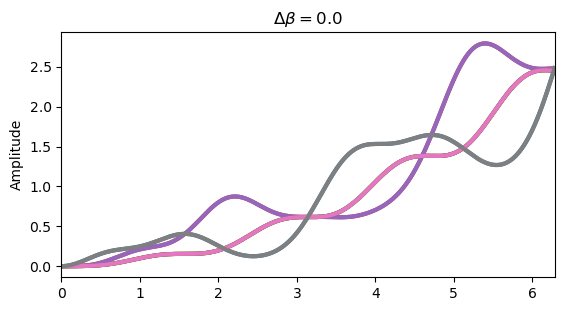

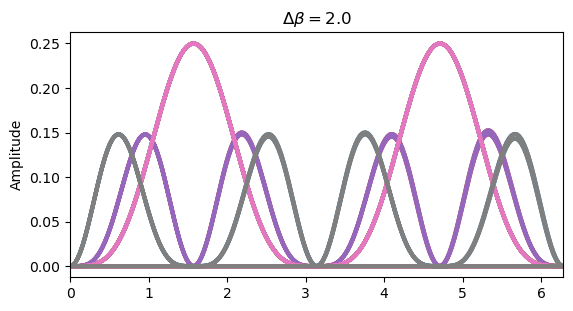

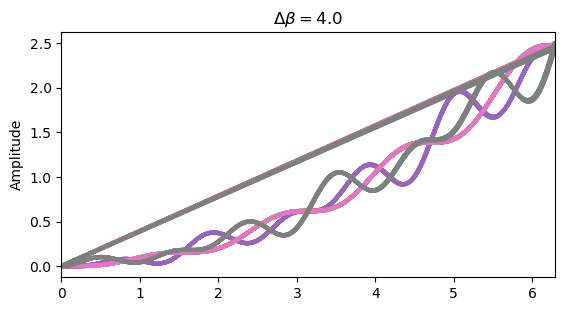

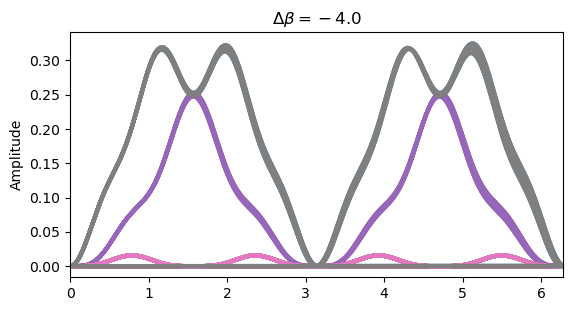

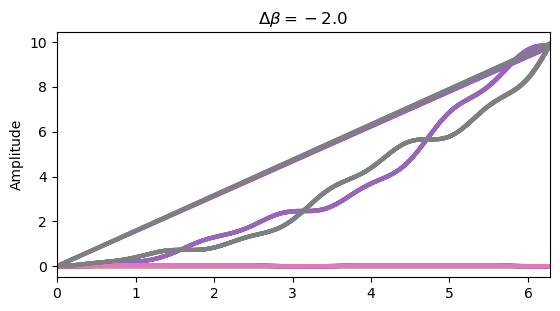

In [133]:
# Plot the wavefuction at fixed z=2pi and \delta \beta = -C3.

main_df = z_prop_C3_2
results_df = calc_resonances(N_waveguides=2,N_photons=3,C_vals=[1,1,2])
resonances = list(set(results_df['Resonance']))

for delB in resonances:
    sub_df=main_df[np.abs(main_df['delBeta'] - delB)<0.01]
    # import seaborn as sns
    #sns.set(font_scale=1.5,style='white', palette='deep',font='Arial',rc = {'figure.figsize':(8,6)})

    # Condensed plot
    plt.figure(figsize=(14,7))

    plt.subplot(221)
    #plt.title(r'$C_2=C_2=2, C_3=4$' +'\n' +r'$A_1=A_2=1+0j, \Delta \beta=-C_3, \Delta \varphi=0$')
    plt.title(r'$\Delta \beta=%s$' %(delB))
    for i in range(len(results_df)):
        plt.plot(sub_df['z'],np.abs(sub_df['Psi%s' %(i)])**2,label='Psi%s' %(i),linewidth=3)
    #plt.axvline(np.pi*1/2,linestyle='--',alpha=0.5,color='k')
    #plt.axvline(np.pi*1,linestyle='--',alpha=0.5,color='k')
    #plt.axvline(np.pi*3/2,linestyle='--',alpha=0.5,color='k')

    plt.xlim(0, 2*np.pi)
    #plt.xticks([0,np.pi/2,np.pi,3*np.pi/2,2*np.pi],[0,'π/2','π','3π/2','2π'])
    #plt.legend(fontsize=15,bbox_to_anchor=(1,1))
    plt.ylabel('Amplitude')
    plt.show()

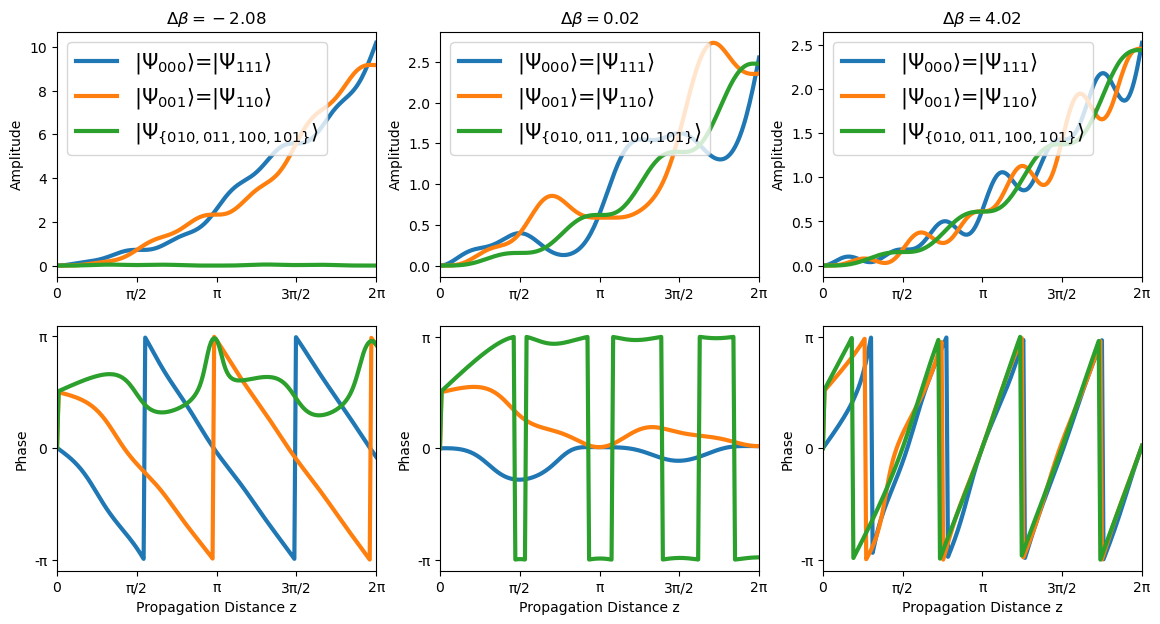

In [134]:
# Plot the wavefuction at fixed z=2pi and \delta \beta = -C3.

sub_df=main_df[main_df['delBeta'] == -2.08]
# import seaborn as sns
#sns.set(font_scale=1.5,style='white', palette='deep',font='Arial',rc = {'figure.figsize':(8,6)})

# Condensed plot
plt.figure(figsize=(14,7))

plt.subplot(231)
#plt.title(r'$C_2=C_2=2, C_3=4$' +'\n' +r'$A_1=A_2=1+0j, \Delta \beta=-C_3, \Delta \varphi=0$')
plt.title(r'$\Delta \beta=-2.08$')
plt.plot(sub_df['z'],np.abs(sub_df['Psi0'])**2,label=r'|$\Psi_{000}\rangle$=|$\Psi_{111}\rangle$',linewidth=3)
plt.plot(sub_df['z'],np.abs(sub_df['Psi4'])**2,label=r'|$\Psi_{001}\rangle$=|$\Psi_{110}\rangle$',linewidth=3)
plt.plot(sub_df['z'],np.abs(sub_df['Psi1'])**2,label=r'|$\Psi_{\{010,011,100,101\}}\rangle$',linewidth=3)
#plt.axvline(np.pi*1/2,linestyle='--',alpha=0.5,color='k')
#plt.axvline(np.pi*1,linestyle='--',alpha=0.5,color='k')
#plt.axvline(np.pi*3/2,linestyle='--',alpha=0.5,color='k')

plt.xlim(0,2*np.pi)
plt.xticks([0,np.pi/2,np.pi,3*np.pi/2,2*np.pi],[0,'π/2','π','3π/2','2π'])
plt.legend(fontsize=15,loc='best')
plt.ylabel('Amplitude')

plt.subplot(234)

plt.plot(sub_df['z'],np.angle(sub_df['Psi0']) ,label=r'|$\Psi_{000}\rangle$=|$\Psi_{111}\rangle$',linewidth=3)
plt.plot(sub_df['z'],np.angle(sub_df['Psi3']) ,label=r'|$\Psi_{001}\rangle$=|$\Psi_{110}\rangle$',linewidth=3)
plt.plot(sub_df['z'],np.angle(sub_df['Psi5']) ,label=r'|$\Psi_{\{010,011,100,101\}}\rangle$',linewidth=3)
#plt.axvline(np.pi*1/2,linestyle='--',alpha=0.5,color='k')
#plt.axvline(np.pi*1,linestyle='--',alpha=0.5,color='k')
#plt.axvline(np.pi*3/2,linestyle='--',alpha=0.5,color='k')

plt.xlabel('Propagation Distance z')
plt.xticks([0,np.pi/2,np.pi,3*np.pi/2,2*np.pi],[0,'π/2','π','3π/2','2π'])
plt.xlim(0,2*np.pi)
plt.yticks([-np.pi,0,np.pi],['-π','0','π'])
plt.ylabel('Phase')
#plt.legend(fontsize=14,loc=2)


sub_df=main_df[main_df['delBeta'] == 0.02]

plt.subplot(232)
#plt.title(r'$C_2=C_2=2, C_3=4$' +'\n' +r'$A_1=A_2=1+0j, \Delta \beta=-C_3, \Delta \varphi=0$')
plt.title(r'$\Delta \beta=0.02$')
plt.plot(sub_df['z'],np.abs(sub_df['Psi0'])**2,label=r'|$\Psi_{000}\rangle$=|$\Psi_{111}\rangle$',linewidth=3)
plt.plot(sub_df['z'],np.abs(sub_df['Psi4'])**2,label=r'|$\Psi_{001}\rangle$=|$\Psi_{110}\rangle$',linewidth=3)
plt.plot(sub_df['z'],np.abs(sub_df['Psi1'])**2,label=r'|$\Psi_{\{010,011,100,101\}}\rangle$',linewidth=3)
#plt.axvline(np.pi*1/2,linestyle='--',alpha=0.5,color='k')
#plt.axvline(np.pi*1,linestyle='--',alpha=0.5,color='k')
#plt.axvline(np.pi*3/2,linestyle='--',alpha=0.5,color='k')

plt.xlim(0,2*np.pi)
plt.xticks([0,np.pi/2,np.pi,3*np.pi/2,2*np.pi],[0,'π/2','π','3π/2','2π'])
plt.legend(fontsize=15,loc='best')
plt.ylabel('Amplitude')

plt.subplot(235)

plt.plot(sub_df['z'],np.angle(sub_df['Psi0']) ,label=r'|$\Psi_{000}\rangle$=|$\Psi_{111}\rangle$',linewidth=3)
plt.plot(sub_df['z'],np.angle(sub_df['Psi3']) ,label=r'|$\Psi_{001}\rangle$=|$\Psi_{110}\rangle$',linewidth=3)
plt.plot(sub_df['z'],np.angle(sub_df['Psi5']) ,label=r'|$\Psi_{\{010,011,100,101\}}\rangle$',linewidth=3)
#plt.axvline(np.pi*1/2,linestyle='--',alpha=0.5,color='k')
#plt.axvline(np.pi*1,linestyle='--',alpha=0.5,color='k')
#plt.axvline(np.pi*3/2,linestyle='--',alpha=0.5,color='k')

plt.xlabel('Propagation Distance z')
plt.xticks([0,np.pi/2,np.pi,3*np.pi/2,2*np.pi],[0,'π/2','π','3π/2','2π'])
plt.xlim(0,2*np.pi)
plt.yticks([-np.pi,0,np.pi],['-π','0','π'])
plt.ylabel('Phase')



sub_df=main_df[main_df['delBeta'] == 4.02]

plt.subplot(233)
#plt.title(r'$C_2=C_2=2, C_3=4$' +'\n' +r'$A_1=A_2=1+0j, \Delta \beta=-C_3, \Delta \varphi=0$')
plt.title(r'$\Delta \beta=4.02$')
plt.plot(sub_df['z'],np.abs(sub_df['Psi0'])**2,label=r'|$\Psi_{000}\rangle$=|$\Psi_{111}\rangle$',linewidth=3)
plt.plot(sub_df['z'],np.abs(sub_df['Psi4'])**2,label=r'|$\Psi_{001}\rangle$=|$\Psi_{110}\rangle$',linewidth=3)
plt.plot(sub_df['z'],np.abs(sub_df['Psi1'])**2,label=r'|$\Psi_{\{010,011,100,101\}}\rangle$',linewidth=3)
#plt.axvline(np.pi*1/2,linestyle='--',alpha=0.5,color='k')
#plt.axvline(np.pi*1,linestyle='--',alpha=0.5,color='k')
#plt.axvline(np.pi*3/2,linestyle='--',alpha=0.5,color='k')

plt.xlim(0,2*np.pi)
plt.xticks([0,np.pi/2,np.pi,3*np.pi/2,2*np.pi],[0,'π/2','π','3π/2','2π'])
plt.legend(fontsize=15,loc='best')
plt.ylabel('Amplitude')

plt.subplot(236)

plt.plot(sub_df['z'],np.angle(sub_df['Psi0']) ,label=r'|$\Psi_{000}\rangle$=|$\Psi_{111}\rangle$',linewidth=3)
plt.plot(sub_df['z'],np.angle(sub_df['Psi3']) ,label=r'|$\Psi_{001}\rangle$=|$\Psi_{110}\rangle$',linewidth=3)
plt.plot(sub_df['z'],np.angle(sub_df['Psi5']) ,label=r'|$\Psi_{\{010,011,100,101\}}\rangle$',linewidth=3)
#plt.axvline(np.pi*1/2,linestyle='--',alpha=0.5,color='k')
#plt.axvline(np.pi*1,linestyle='--',alpha=0.5,color='k')
#plt.axvline(np.pi*3/2,linestyle='--',alpha=0.5,color='k')

plt.xlabel('Propagation Distance z')
plt.xticks([0,np.pi/2,np.pi,3*np.pi/2,2*np.pi],[0,'π/2','π','3π/2','2π'])
plt.xlim(0,2*np.pi)
plt.yticks([-np.pi,0,np.pi],['-π','0','π'])
plt.ylabel('Phase')


plt.savefig('AWtesting_NoXPMC112fig2')
plt.show()

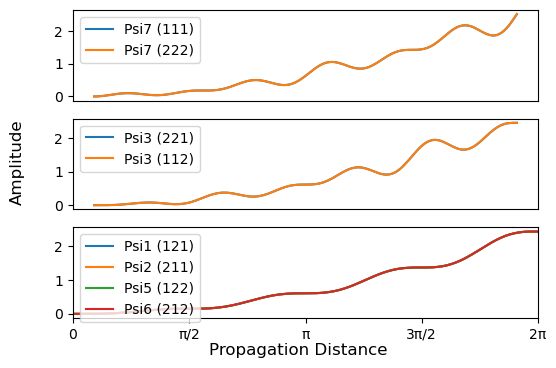

In [136]:
# Individual plots showing the equivalence of the wavefunctions 

fig = plt.figure(figsize=(6,4))

ax1 = fig.add_subplot(311)
ax1.plot(sub_df['z'],np.abs(sub_df['Psi0'])**2,label='Psi7 (111)')
ax1.plot(sub_df['z'],np.abs(sub_df['Psi7'])**2,label='Psi7 (222)')
ax1.legend()
ax1.set_xticks([])

ax2 = fig.add_subplot(312)
ax2.plot(sub_df['z'],np.abs(sub_df['Psi3'])**2,label='Psi3 (221)')
ax2.plot(sub_df['z'],np.abs(sub_df['Psi4'])**2,label='Psi3 (112)')
ax2.set_xticks([])
ax2.legend()

ax3 = fig.add_subplot(313)
ax3.plot(sub_df['z'],np.abs(sub_df['Psi1'])**2,label='Psi1 (121)')
ax3.plot(sub_df['z'],np.abs(sub_df['Psi2'])**2,label='Psi2 (211)')
ax3.plot(sub_df['z'],np.abs(sub_df['Psi5'])**2,label='Psi5 (122)')
ax3.plot(sub_df['z'],np.abs(sub_df['Psi6'])**2,label='Psi6 (212)')
ax3.legend(loc=2)
ax3.set_xticks([0,np.pi/2,np.pi,3*np.pi/2,2*np.pi],[0,'π/2','π','3π/2','2π'])
ax3.set_xlim(0,2*np.pi)

fig.supxlabel('Propagation Distance')
fig.supylabel('Amplitude')
plt.show()

## Workspace 2 - N=2, C dependence

C - dependence of Heralded Bell State (HBS) and Factorisable (Perfectly-Mixed) State (FS)

### Solver. N=2. Fixed z=2pi, $\Delta \beta$=-C3 (0), iterate over C1=C2 and C3 for HBS (FS)

In [ ]:
n_photon = 3
n_wg = 2

init_C1 = 0.1
init_C2 = 0.1
max_z = 2*np.pi
zs=np.linspace(0,max_z,50)
zs=[max_z]

init_gamma = 1
init_del_beta = -2*np.pi
init_del_phi = 0


Ez0 = [1 + 0j, 1 + 0j] 
Psi0 = [0] * (n_wg**n_photon)
Ez_Psi0 = Ez0 + Psi0

#delBeta_range = np.linspace(-1.8,1.8,50)
delPhi_range = np.arange(-2*3.14,2*3.14+0.01,0.01)
C3_list=np.arange(0,3+0.01,0.01)
C1_list=np.arange(0.1,3+0.01,0.01)

df_list= [] 
for C1 in C1_list:
    for C3 in C3_list:
        
        C1 = round(C1,2)
        C3 = round(C3,2)
        delBeta = -C3
        Ez_Psi = solve_ivp(TOSPDC_nwg_2
                            , [0, max_z]
                            , Ez_Psi0
                            # , max_step=max_step_z  # comment out if the "t_eval=" is specified
                            , t_eval=zs
                            , dense_output=True
                            , args=(C1, C1, C3, init_gamma, delBeta, 0)) 

        data = pd.DataFrame(Ez_Psi.y.transpose(),columns=['Ez1','Ez2','Psi0','Psi1','Psi2','Psi3','Psi4','Psi5','Psi6','Psi7'])
        data['z'] = Ez_Psi.t
        data.insert(0, 'z', data.pop('z')) 

        Psi = data[['Psi0', 'Psi1', 'Psi2', 'Psi3', 'Psi4', 'Psi5', 'Psi6', 'Psi7']]
        Psi = np.array(Psi)
        norm_fac = np.sqrt(np.sum(np.abs(Psi)**2))

        # Include metadata
        data['NormFac'] = norm_fac
        data['C1'] = C1
        data['C2'] = C1
        data['C3'] = C3
        data['Gamma'] = init_gamma
        data['delBeta'] = delBeta
        data['delPhi'] = round(delBeta, 3)
        df_list.append(data)
    
main_df2 = pd.concat(df_list,ignore_index=True)
#main_df2.to_csv('240702 - SPDC-Waveguide-Data/240702_solution_C1=C2sweep_C3sweep_delB=-C3_z=2pi.csv')

### Post-process HBS & FS Data

In [138]:
# Read data for HBS
C3sweep_HBS = read_csv2('240702 - Data/240702_solution_C1=C2sweep_C3sweep_delB=-C3_z=2pi.csv')

In [139]:
# Read data for FS
C3sweep_FS = read_csv2('240702 - Data/240702_solution_C1=C2sweep_C3sweep_delB=0_z=2pi.csv')

In [147]:

def plot_C3_dependence(main_df):
    C3_list = list(set(main_df['C3']))
    C3_list.sort()
    delBetas = list(set(main_df['delBeta']))
    delBetas.sort()

    fig, axes = plt.subplots(nrows=2, ncols=4,figsize=(10,5),layout='constrained')
    loop_n=0
    max_C3 = 3
    for k,ax in zip(Psi_index_plot_n2,axes.flat):
        array_2d = []
        loop_n=loop_n+1
        for C3 in C3_list:
            #subdf = main_df[main_df['C3'] == C3]
            subdf = main_df[np.abs(main_df['C3']-C3) < 0.001]
            # subdf = subdf[subdf['z'] == zs[-1]]
            # array_2d.append(np.square(np.abs(subdf['Psi%s' %(str(k))])))
            array_2d.append(np.array(np.square(np.abs(subdf['Psi%s' %(str(k))]))))
        #    plt.plot(np.square(np.abs(subdf['Psi5'])))
        # plt.subplot(2,4,loop_n)
        ax.set_title(r'$|\psi_{%s}|^2$' %(str(Psi_index_n2[k])))
        im = ax.imshow(np.transpose(array_2d),extent=(0, 3,0.1,3) ,origin='lower',aspect='auto')#,aspect='auto')
        #ax.axvline(4.28,linestyle='--',color='white')
        #if loop_n in [1,2,7,8]:
            #ax.plot([0,-max_C3],[0,max_C3],linestyle='--',color='white')
        #else:
            #ax.plot([0,-max_C3],[0,max_C3],linestyle='--',color='white')
            #ax.plot([-max_C3,0],[0,max_C3],linestyle='-.',color='k')
            #ax.plot([max_C3,2*max_C3],[0,max_C3],linestyle='-.',color='k')
        #ax.set_xticks([-2*np.pi,-np.pi,0,np.pi,2*np.pi], ['-2π','-π','0','π','2π'])
        #ax.set_yticks([0,1,2],[0,'1','2'])
        ax.set_ylabel('C1=C2')
        ax.set_xlabel('C3')
        #im.colorbar(fraction=0.046, pad=0.04,label='Intensity')     
        plt.colorbar(im,ax=ax,shrink=1)
    #fig.colorbar(im, ax=axes.ravel().tolist(),shrink=0.85)
    #fig.xlabel(r'$\Delta \phi$')
    plt.show()

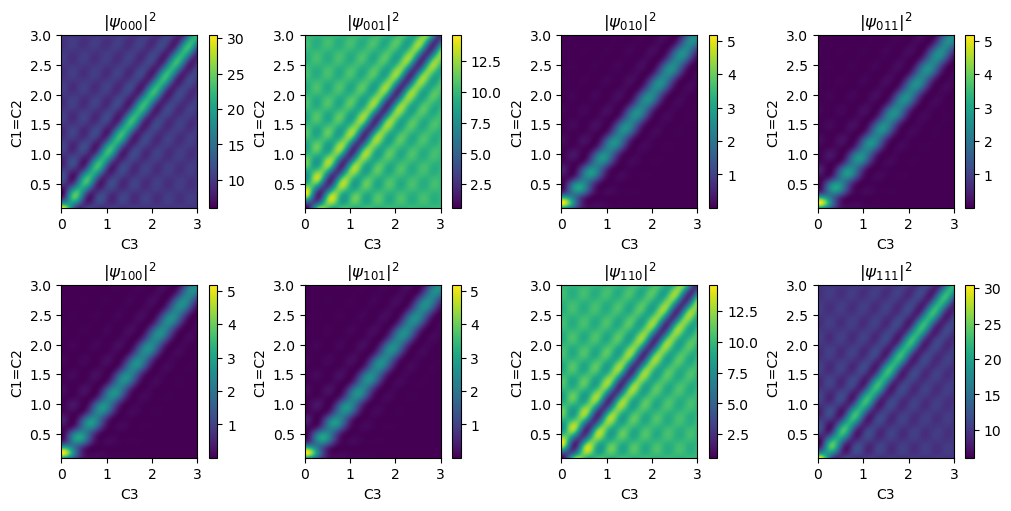

In [148]:
plot_C3_dependence(C3sweep_HBS)

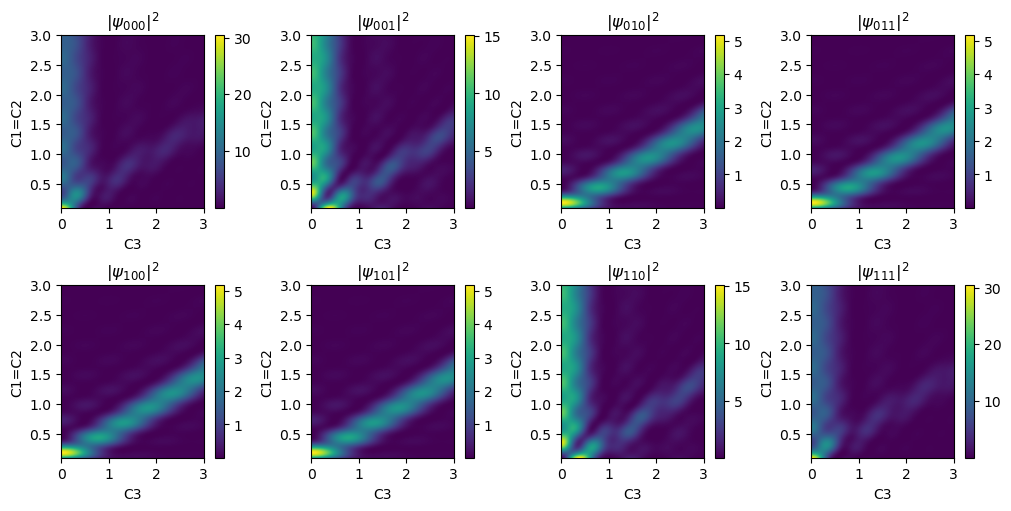

In [149]:
plot_C3_dependence(C3sweep_FS)

In [150]:
Psi_ref = C3sweep_FS.iloc[-1]
norm_fac = np.sqrt(np.sum(np.abs(Psi_ref[['Psi0', 'Psi1', 'Psi2', 'Psi3', 'Psi4', 'Psi5', 'Psi6', 'Psi7']])**2))

C3_list = list(set(C3sweep_FS['C3']))
C3_list.sort()

C1_list = list(set(C3sweep_FS['C1']))
C1_list.sort()

array_2d_bell = []
array_2d_herald = []
array_2d_others = []
for C3 in C3_list:
    subdf = C3sweep_FS[C3sweep_FS['C3'] == C3]
    
    bell_state = np.array(np.square(np.abs(subdf['Psi0']/norm_fac)))
    herald_state = np.array(np.square(np.abs(subdf['Psi3']/norm_fac)))
    others = np.array(np.square(np.abs(subdf['Psi1']/norm_fac)))
    
    array_2d_bell.append(bell_state)
    array_2d_herald.append(herald_state)
    array_2d_others.append(others)



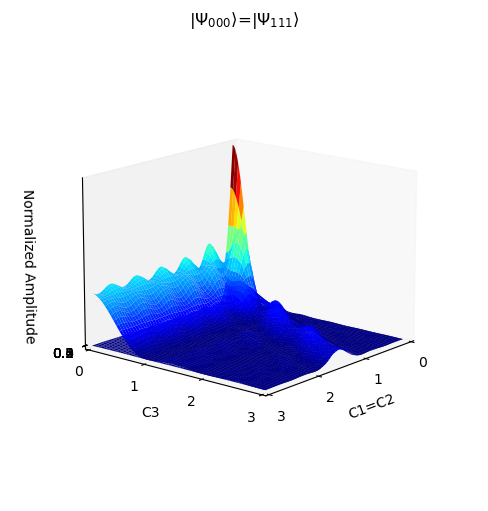

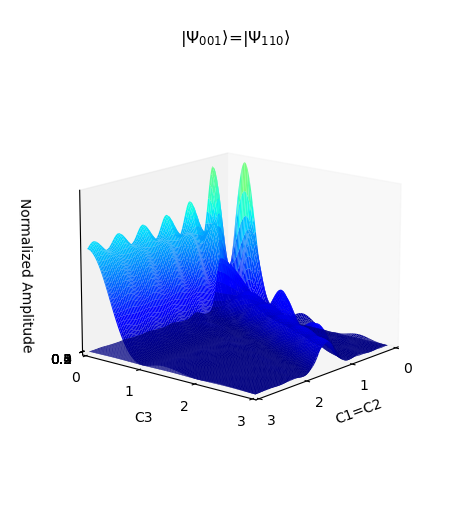

In [151]:
# Plot 3D dependence

X, Y = np.meshgrid(C1_list, C3_list)
Z_bell = np.array(array_2d_bell)
Z_herald = np.array(array_2d_herald)
Z_others = np.array(array_2d_others)

col_bell = cm.jet(Z_bell/np.amax(Z_bell))
col_herald = cm.jet(Z_herald/np.amax(Z_bell))
col_others = cm.jet(Z_others/np.amax(Z_bell))

# First subplot
fig1 = plt.figure(figsize=(5,5),layout='constrained')
ax3d = fig1.add_subplot(1, 1, 1,projection="3d")
im3d = ax3d.plot_surface(X, Y, Z_bell, cmap="plasma",rstride=5, cstride=5,linewidth=0, antialiased=True, facecolors=col_bell)
ax3d.plot_surface(X, Y, Z_others, cmap="plasma",rstride=5, cstride=5,linewidth=0, antialiased=True,facecolors=col_others)
ax3d.set_title(r'|$\Psi_{000}\rangle$=|$\Psi_{111}\rangle$')
ax3d.set_xlabel("\nC1=C2")
ax3d.set_ylabel("\nC3")
ax3d.set_zlabel("\nNormalized Amplitude")
ax3d.set_xlim(0,3)
ax3d.set_ylim(0,3)
#ax3d.set_zlim(0,30)
ax3d.set_xticks([0,1,2,3])
ax3d.set_yticks([0,1,2,3])
ax3d.set_zticks([0,0.1,0.2,0.3,0.4,0.5])
ax3d.view_init(elev=15, azim=40, roll=0)
ax3d.grid(False)
ax3d.set_box_aspect((1,1,0.75), zoom=0.78)
plt.show()

# Second subplot
fig2 = plt.figure(figsize=(5,5),layout='constrained')
ax3d2 = fig2.add_subplot(1, 1, 1,projection="3d")
ax3d2.plot_surface(X, Y, Z_herald, cmap="plasma",rstride=3, cstride=3,linewidth=0, antialiased=True,edgecolor=None,facecolors=col_herald)
ax3d2.plot_surface(X, Y, Z_others, cmap="plasma",rstride=3, cstride=3,linewidth=0, antialiased=True,facecolors=col_others)
plt.title('\n'+r'|$\Psi_{001}\rangle$=|$\Psi_{110}\rangle$')
#ax3d2.set_title(r'|$\Psi_{\{010,011,100,101\}}\rangle$')
ax3d2.set_zlabel("\nNormalized Amplitude")
ax3d2.set_xlabel("\nC1=C2")
ax3d2.set_ylabel("\nC3")
ax3d2.set_xticks([0,1,2,3])
ax3d2.set_yticks([0,1,2,3])
ax3d2.set_zticks([0,0.1,0.2,0.3,0.4,0.5])
#ax3d2.set_zlim(0,0.002)
ax3d2.set_xlim(0,3)
ax3d2.set_ylim(0,3)
ax3d2.view_init(elev=15, azim=40, roll=0)
ax3d2.grid(False)
ax3d2.set_box_aspect((1,1,0.75), zoom=0.78)
#fig2.tight_layout()                  
#fig2.subplots_adjust(top=15,bottom=10)
#plt.colorbar(im3d2, ax=ax3d2,shrink=1)

plt.show()

In [152]:
# Select Heralded Bell States
C3sweep_HBS_C1_1=C3sweep_HBS[C3sweep_HBS['C1']==1]

# Select Uniform States
C3sweep_FS_C1_1=C3sweep_FS[C3sweep_FS['C1']==1]

In [156]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

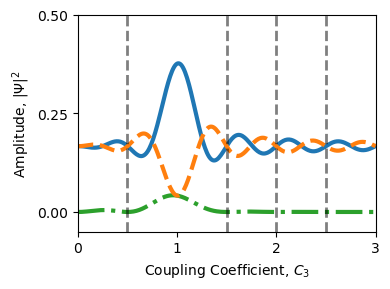

In [158]:
sub_df = C3sweep_HBS_C1_1
norm_fac = C3sweep_HBS_C1_1['NormFac'].max()
plt.figure(figsize=(4,3),layout='tight')
#plt.title(r'$C_1=C_2=1$')
#plt.plot(sub_df['C3'],np.abs(sub_df['Psi1'])**2,label=r'|$\Psi_{121}\rangle$=|$\Psi_{122}\rangle$=|$\Psi_{211}\rangle$=|$\Psi_{212}\rangle$',linewidth=3)

#plt.plot(sub_df['C3'],50*np.abs(sub_df['Psi1']/norm_fac)**2,linewidth=2,alpha=0.5,color='C2',linestyle='--')
plt.plot(sub_df['C3'],np.abs(sub_df['Psi1']/norm_fac)**2,label=r'$\Psi_{\{010,011,100,101 \}}$',linestyle='-.',linewidth=3,color='C2')
plt.plot(sub_df['C3'],np.abs(sub_df['Psi0']/norm_fac)**2,label=r'$\Psi_{000}=\Psi_{111}$',linestyle='-',linewidth=3,color="C0")
plt.plot(sub_df['C3'],np.abs(sub_df['Psi4']/norm_fac)**2,label=r'$\Psi_{001}=\Psi_{110}$',linestyle='--',linewidth=3,color='C1')


C1=1

# Iterate over arbitrary integer m (Solution for \delBeta=-C3)
for m in [-1,1,2,3]:
    C3 = 0.5*m + C1
    if C3**2==C1**2:
        continue
    else:
        plt.axvline(C3,linestyle='--',alpha=0.5,color='k',linewidth=2)   

plt.xlim(0,3)
plt.xticks(np.arange(0,4,1))
plt.ylim(-0.05,0.5)
plt.yticks([0,0.25,0.5])



plt.xlabel(r'Coupling Coefficient, $C_3$')
plt.ylabel(r'Amplitude, $|\Psi|^2$')
#plt.grid()

plt.show()

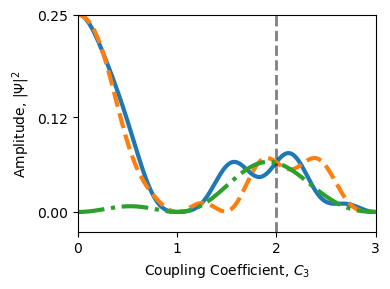

In [159]:
sub_df = C3sweep_FS_C1_1
norm_fac = C3sweep_FS_C1_1['NormFac'].max()
plt.figure(figsize=(4,3),layout='tight')

#plt.title(r'$C_1=C_2=1$')
#plt.plot(sub_df['C3'],np.abs(sub_df['Psi1'])**2,label=r'|$\Psi_{121}\rangle$=|$\Psi_{122}\rangle$=|$\Psi_{211}\rangle$=|$\Psi_{212}\rangle$',linewidth=3)

#plt.plot(sub_df['C3'],50*np.abs(sub_df['Psi1']/norm_fac)**2,linewidth=2,alpha=0.5,color='C2',linestyle='--')
plt.plot(sub_df['C3'],np.abs(sub_df['Psi0']/norm_fac)**2,label=r'|$\Psi_{000}\rangle$=|$\Psi_{111}\rangle$',linestyle='-',linewidth=3,color='C0')
plt.plot(sub_df['C3'],np.abs(sub_df['Psi4']/norm_fac)**2,label=r'|$\Psi_{001}\rangle$=|$\Psi_{110}\rangle$',linestyle='--',linewidth=3,color='C1')
plt.plot(sub_df['C3'],np.abs(sub_df['Psi1']/norm_fac)**2,label=r'|$\Psi_{\{010,011,100,101 \}}\rangle$',linestyle='-.',linewidth=3,color='C2')
plt.axvline(2,linestyle='--',alpha=0.5,color='k',linewidth=2)   

plt.xlim(0,3)
plt.ylim(-0.025,0.25)
plt.yticks([0,0.12,0.25])
plt.xticks(np.arange(0,4,1))
"""
plt.legend(fontsize=35,
           ncols=1,
           bbox_to_anchor=(0.5,1),
           alignment='center',
           loc='lower center',
           labelspacing=0,
           columnspacing=0,
           framealpha=0.5)
"""
plt.xlabel(r'Coupling Coefficient, $C_3$')
plt.ylabel(r'Amplitude, $|\Psi|^2$')
#plt.grid()

plt.show()


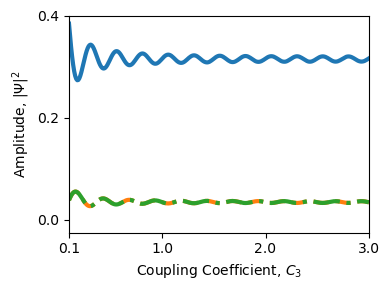

In [162]:
#example_GHZ = calc_wfcn(1, 1, 1)
sub_df = C3sweep_GHZ_1 = C3sweep_HBS[(C3sweep_HBS['delBeta']==-C3sweep_HBS['C3']) & (C3sweep_HBS['C3']==C3sweep_HBS['C1'])]
norm_fac = sub_df['NormFac'].max()
plt.figure(figsize=(4,3),layout='tight')
#plt.title(r'$C_1=C_2=1$')
#plt.plot(sub_df['C3'],np.abs(sub_df['Psi1'])**2,label=r'|$\Psi_{121}\rangle$=|$\Psi_{122}\rangle$=|$\Psi_{211}\rangle$=|$\Psi_{212}\rangle$',linewidth=3)

#plt.plot(sub_df['C3'],50*np.abs(sub_df['Psi1']/norm_fac)**2,linewidth=2,alpha=0.5,color='C2',linestyle='--')
plt.plot(sub_df['C3'],np.abs(sub_df['Psi0']/norm_fac)**2,label=r'|$\Psi_{000}\rangle$=|$\Psi_{111}\rangle$',linestyle='-',linewidth=3,color='C0')
plt.plot(sub_df['C3'],np.abs(sub_df['Psi4']/norm_fac)**2,label=r'|$\Psi_{001}\rangle$=|$\Psi_{110}\rangle$',linestyle='--',linewidth=3,color='C1')
plt.plot(sub_df['C3'],np.abs(sub_df['Psi1']/norm_fac)**2,label=r'|$\Psi_{\{010,011,100,101 \}}\rangle$',linestyle='-.',linewidth=3,color='C2')
plt.axvline(-1,linestyle='--',alpha=0.5,color='k',linewidth=2)   

plt.xlim(0.1,3)
plt.ylim(-0.025,0.4)
plt.yticks([0,0.2,0.4])
plt.xticks([0.1,1,2,3])
#plt.legend(fontsize=19,loc='best')
plt.xlabel(r'Coupling Coefficient, $C_3$')
plt.ylabel(r'Amplitude, $|\Psi|^2$')
#plt.grid()

plt.show()


## Workspace 3 - N=2, Density matrix

To plot the density matrices of HBS, FS, and GHZ-like states

### Solver. Fixed z=2pi, delBeta, C

In [164]:
def solve_wfcn(init_C1, init_C2, C3, delBeta):
    n_photon = 3
    n_wg = 2

    max_z = 2*np.pi
    zs=np.linspace(0,max_z,100)
    zs=[max_z]

    init_gamma = 1
    init_del_beta = 0
    init_del_phi = 0


    Ez0 = [1 + 0j, 1 + 0j] 
    Psi0 = [0] * (n_wg**n_photon)
    Ez_Psi0 = Ez0 + Psi0



    Ez_Psi = solve_ivp(TOSPDC_nwg_2
                        , [0, max_z]
                        , Ez_Psi0
                        # , max_step=max_step_z  # comment out if the "t_eval=" is specified
                        , t_eval=zs
                        , dense_output=True
                        , args=(init_C1, init_C2, C3, init_gamma, delBeta, 0)) 

    data = pd.DataFrame(Ez_Psi.y.transpose(),columns=['Ez1','Ez2','Psi0','Psi1','Psi2','Psi3','Psi4','Psi5','Psi6','Psi7'])
    data['z']=Ez_Psi.t
    data.insert(0, 'z', data.pop('z')) 
    #print(data)

    Psi = data[['Psi0', 'Psi1', 'Psi2', 'Psi3', 'Psi4', 'Psi5', 'Psi6', 'Psi7']]
    Psi = np.array(Psi)
    norm_fac = np.sqrt(np.sum(np.abs(Psi)**2))

    # Include metadata
    data['NormFac'] = norm_fac
    data['C1'] = init_C1
    data['C2'] = init_C2
    data['C3'] = C3
    data['Gamma'] = init_gamma
    data['delBeta'] = round(delBeta,3)
    data['delPhi'] = 0

    return data

In [165]:
example_HBS = solve_wfcn(1, 1, 2,-2)
example_FS = solve_wfcn(1, 1, 2,0)
example_GHZ = solve_wfcn(0.1, 0.1, 0.1, 0)

### Analyze and plot results

In [166]:
Psi_norm = np.array(main_df[['Psi0', 'Psi1', 'Psi2', 'Psi3', 'Psi4', 'Psi5', 'Psi6', 'Psi7']].iloc[-1])/main_df['NormFac'].iloc[-1]
den_mat = np.outer(Psi_norm,Psi_norm)
den_mat_real = np.outer(Psi_norm,Psi_norm).real
den_mat_real = np.savetxt('den_mat_real_AWtest_C1=C2=C31_C3=0.1trial3.csv', den_mat_real, delimiter = ",")
#den_mat_real = np.savetxt('den_mat_real_GHZ_C1=C2=C31_C3=0.1.csv', den_mat_real, delimiter = ",")

In [167]:
main_df[['Psi0', 'Psi1', 'Psi2', 'Psi3', 'Psi4', 'Psi5', 'Psi6', 'Psi7', 'delBeta']].iloc[-1]

Psi0       0.205764+0.249143j
Psi1       0.068243+0.082905j
Psi2       0.068243+0.082905j
Psi3       0.087134+0.105740j
Psi4       0.087134+0.105740j
Psi5       0.068243+0.082905j
Psi6       0.068243+0.082905j
Psi7       0.205764+0.249143j
delBeta    6.280000+0.000000j
Name: 251399, dtype: complex128

In [ ]:
def plot_density_matrix(main_df):
    # plt.rcParams.update({'font.size': 18})
    states = ['000','010','100','110','001','011','101','111']
    Psi_norm = np.array(main_df[['Psi0', 'Psi1', 'Psi2', 'Psi3', 'Psi4', 'Psi5', 'Psi6', 'Psi7']].iloc[0])/main_df['NormFac'].iloc[0]
    den_mat = np.outer(Psi_norm,Psi_norm)
    den_mat_real = np.outer(Psi_norm,Psi_norm).real
    plt.imshow(den_mat_real,cmap='bwr')
    plt.xticks([0,1,2,3,4,5,6,7],labels=states,rotation=45)
    plt.yticks([0,1,2,3,4,5,6,7],labels=states)
    plt.xlabel(r'|$\Psi\rangle$')
    plt.ylabel(r'|$\Psi\rangle$')
    plt.colorbar(label=r'|$\Psi\rangle \langle \Psi| $')
    plt.show()
    
def plot_density_matrix_imag(main_df):
    states = ['000','010','100','110','001','011','101','111']
    Psi_norm = np.array(main_df[['Psi0', 'Psi1', 'Psi2', 'Psi3', 'Psi4', 'Psi5', 'Psi6', 'Psi7']].iloc[0])/main_df['NormFac'].iloc[0]
    den_mat = np.outer(Psi_norm,Psi_norm)
    den_mat_real = np.outer(Psi_norm,Psi_norm).imag
    plt.imshow(den_mat_real,cmap='bwr')
    plt.xticks([0,1,2,3,4,5,6,7],labels=states,rotation=45)
    plt.yticks([0,1,2,3,4,5,6,7],labels=states)
    plt.xlabel(r'|$\Psi\rangle$')
    plt.ylabel(r'|$\Psi\rangle$')
    plt.colorbar(label=r'|$\Psi\rangle \langle \Psi| $')
    plt.show()

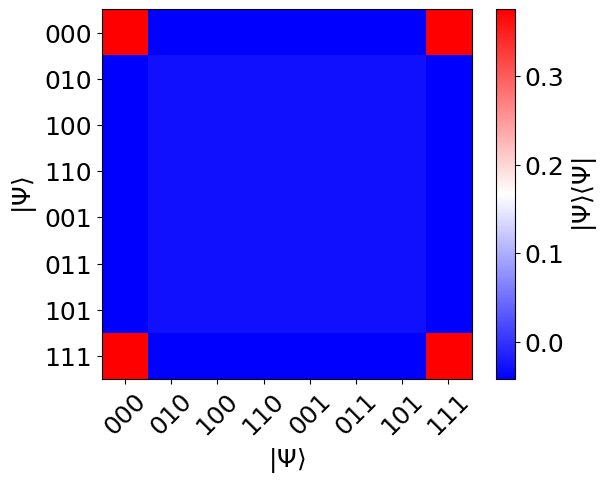

In [169]:
plot_density_matrix(example_GHZ)

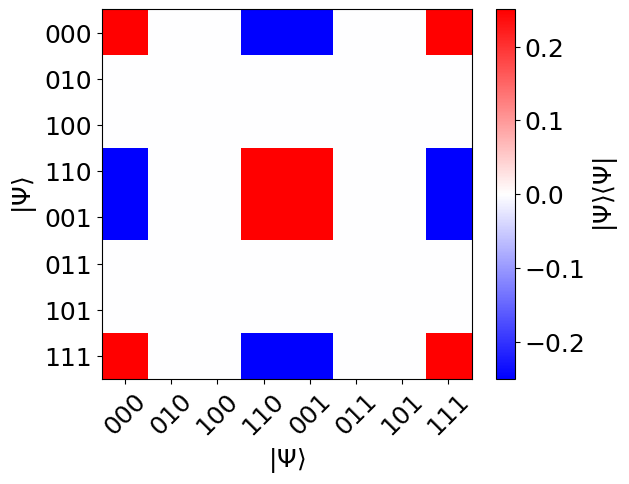

In [170]:
plot_density_matrix(example_HBS)

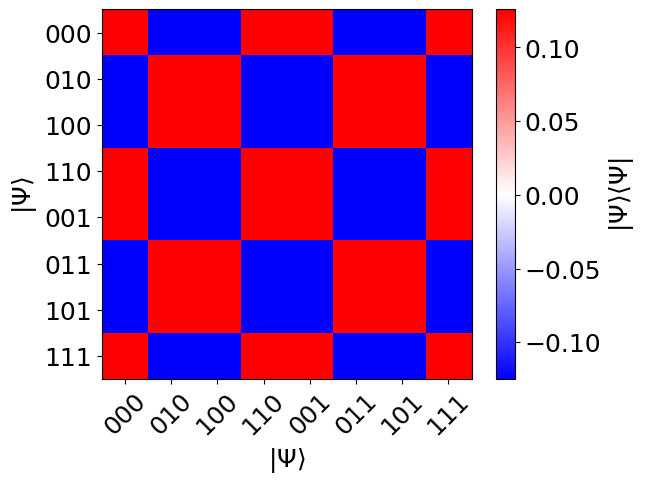

In [171]:
plot_density_matrix(example_FS)

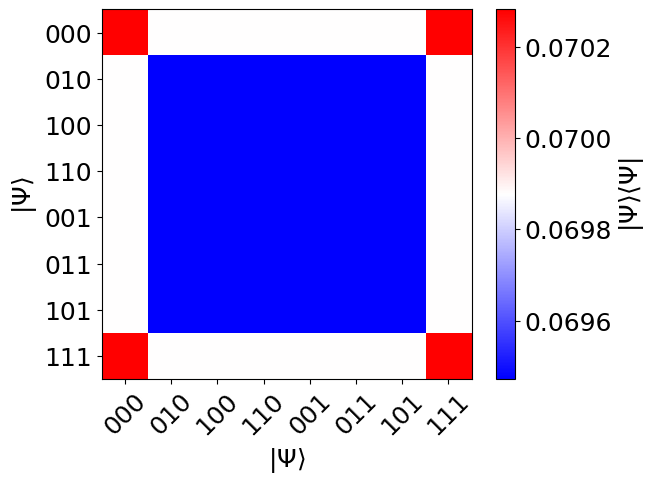

In [173]:
plot_density_matrix(solve_wfcn(1, 1, 1, 0))

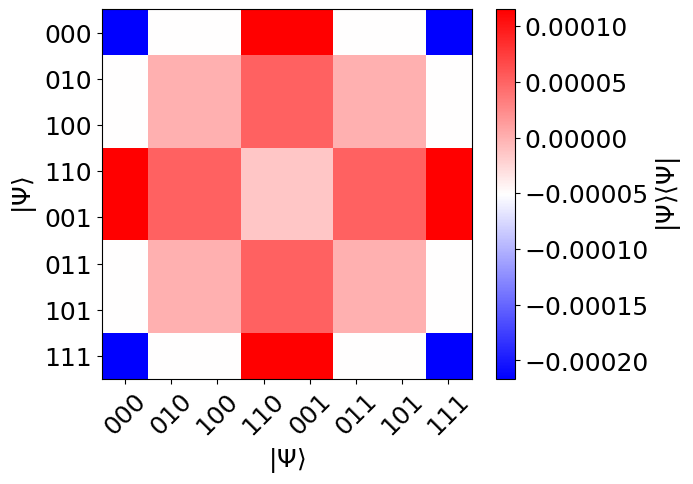

In [174]:
plot_density_matrix_imag(example_HBS)

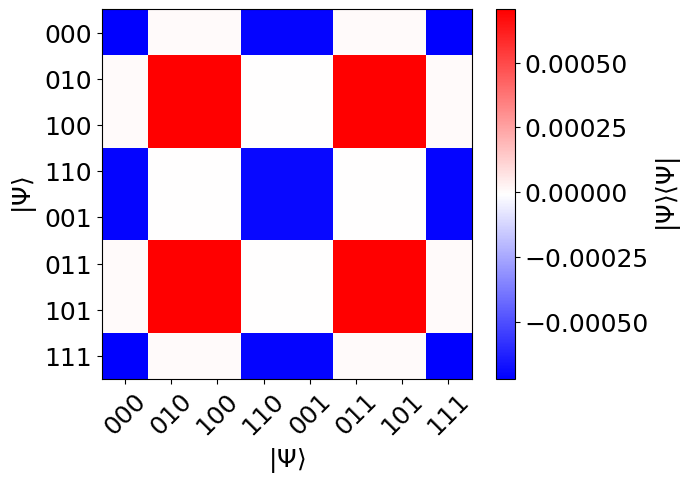

In [175]:
plot_density_matrix_imag(example_FS)

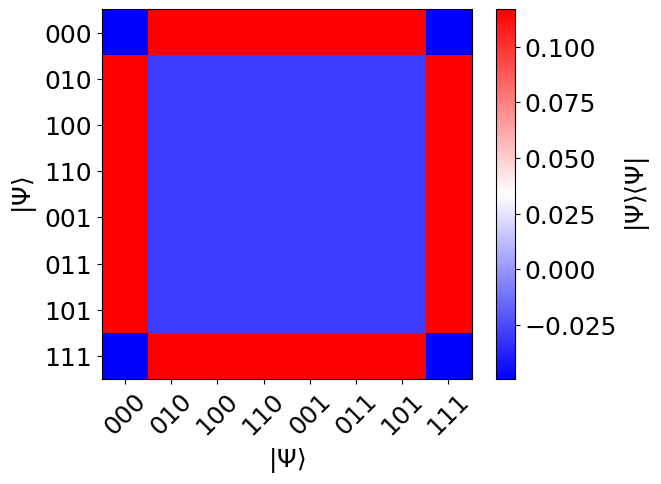

In [176]:
plot_density_matrix_imag(example_GHZ)

## Workspace 4 - N=2 with SPM

### Solver

In [196]:
n_photon = 3
n_wg = 2

C1 = 1
C2 = 1
C3 = 1

max_z = 2*np.pi
zs=np.linspace(0,max_z,200)

gamma = 1
delBeta = 0
delPhi = 0

Ez0 = [1 + 0j] *n_wg                 # Complex amplitude of pump at waveguide 1 and 2
Psi0 = [0] * (n_wg**n_photon)        # Initial three-photon wavefunction set to zero
Ez_Psi0 = Ez0 + Psi0

delBeta_range = np.arange(-2*3.14,3*3.14+0.2,0.2)
#delBeta_range = [0.0, 1.41421, 2.82843, 4.24264, -4.24264, -2.82843, -1.41421]

df_list= []
#for delBeta in delBeta_range:
for delBeta in delBeta_range:
    Ez_Psi = solve_ivp(TOSPDC_nwg_2_SPM
                        , [0, max_z]
                        , Ez_Psi0
                        # , max_step=max_step_z  # comment out if the "t_eval=" is specified
                        , t_eval=zs
                        , dense_output=True
                        , args=(C1, C2, C3, gamma, delBeta, delPhi)) 

    columns = []
    columns2 = []     
    for i in range(0,n_wg):
        column_name = 'Ez' + str(i)
        columns.append(column_name)
    for i in range(0, n_wg**n_photon):
        column_name = 'Psi' + str(i)
        columns.append(column_name)
        columns2.append(column_name)
        
    data = pd.DataFrame(Ez_Psi.y.transpose(),columns=columns)
    data['z']=Ez_Psi.t
    data.insert(0, 'z', data.pop('z')) 
    
    Psi = data[columns2]
    Psi = np.array(Psi)
    norm_fac = np.sqrt(np.sum(np.abs(Psi)**2))

    # Include metadata
    data['NormFac'] = norm_fac
    data['C1'] = C1
    data['C2'] = C2
    data['C3'] = C3
    data['Gamma'] = gamma
    data['delBeta'] = round(delBeta, 3)
    data['delPhi'] = delPhi
    df_list.append(data)

main_df = pd.concat(df_list,ignore_index=True)

# Externally save file if working on large and multiple dataframes
# main_df.to_csv('250409 - Data/250409_solution_C1=C2=C3=1_delBsweep_zsweep.csv')


### Analyze and plot

In [199]:
Psi_index_n2 =  {0: '000', 1: '010',
                 2: '100', 3: '110',
                 4: '001', 5: '011',
                 6: '101', 7: '111'}

Psi_index_plot_n2 = [0,4,1,5,2,6,3,7] # Sequence change for plotting purposes

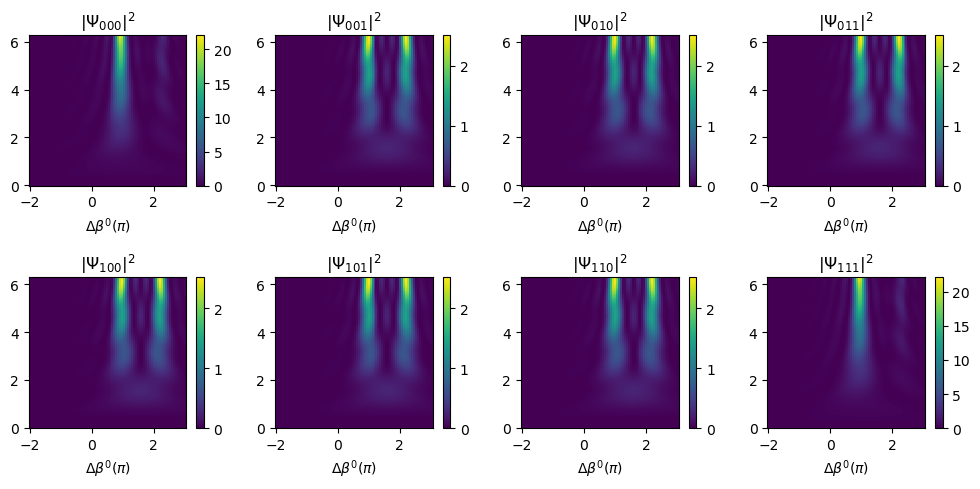

In [202]:
plot_all_wfcn(main_df,[],Psi_index_n2,Psi_index_plot_n2)

## Workspace 5 - N=3, Z and Beta dependence

### Solver

In [208]:
n_photon = 3
wg_num = 3

C3 = 1
init_C1 = 1
init_C2 = 1
max_z = 17.7317             # z=96pi/17 for 12 cycles or z=8pi/17 per cycle
zs=np.linspace(0,max_z,100)
#zs=[max_z]


init_gamma = 1
init_del_beta = 0
init_del_phi = 0


#Ez0 = [1 + 0j] *wg_num                 # Complex amplitude of pump at waveguide 1 and 2
Ez0 = [1+0j, 1+0j, 1+0j] 
Psi0 = [0] * (wg_num**n_photon)           # Initial wavefunction set to zero
Ez_Psi0 = Ez0 + Psi0

#Make 0.01 to 0.1/0.5
delBeta_range = np.arange(-2*3.14,3*3.14+0.1,0.1)

df_list= []
for delBeta in delBeta_range:
    Ez_Psi = solve_ivp(TOSPDC_nwg_3
                        , [0, max_z]
                        , Ez_Psi0
                        # , max_step=max_step_z  # comment out if the "t_eval=" is specified
                        , t_eval=zs
                        , dense_output=True
                        , args=(init_C1, init_C2, C3, init_gamma, delBeta, init_del_phi)) 

    columns = []
    columns2 = []
    for i in range(0,wg_num):
        column_name = 'Ez' + str(i)
        columns.append(column_name)
    for i in range(0, wg_num**n_photon):
        column_name = 'Psi' + str(i)
        columns.append(column_name)
        columns2.append(column_name)
        
    data = pd.DataFrame(Ez_Psi.y.transpose(),columns=columns)
    data['z']=Ez_Psi.t
    data.insert(0, 'z', data.pop('z')) 
    
    Psi = data[columns2]
    Psi = np.array(Psi)
    norm_fac = np.sqrt(np.sum(np.abs(Psi)**2))

    # Include metadata
    data['NormFac'] = norm_fac
    data['C1'] = init_C1
    data['C2'] = init_C2
    data['C3'] = C3
    data['Gamma'] = init_gamma
    data['delBeta'] = round(delBeta, 3)
    data['delPhi'] = init_del_phi
    df_list.append(data)

main_df = pd.concat(df_list,ignore_index=True)

### Analyze and plot results

In [197]:
Psi_index_n3 = []
for l in range(0,wg_num):
    for m in range(0,wg_num):
        for n in range(0,wg_num):
            entry = str(l)+str(m)+str(n)
            Psi_index_n3.append(entry)

Psi_index_plot_n3 = list(range(0, wg_num**n_photon))

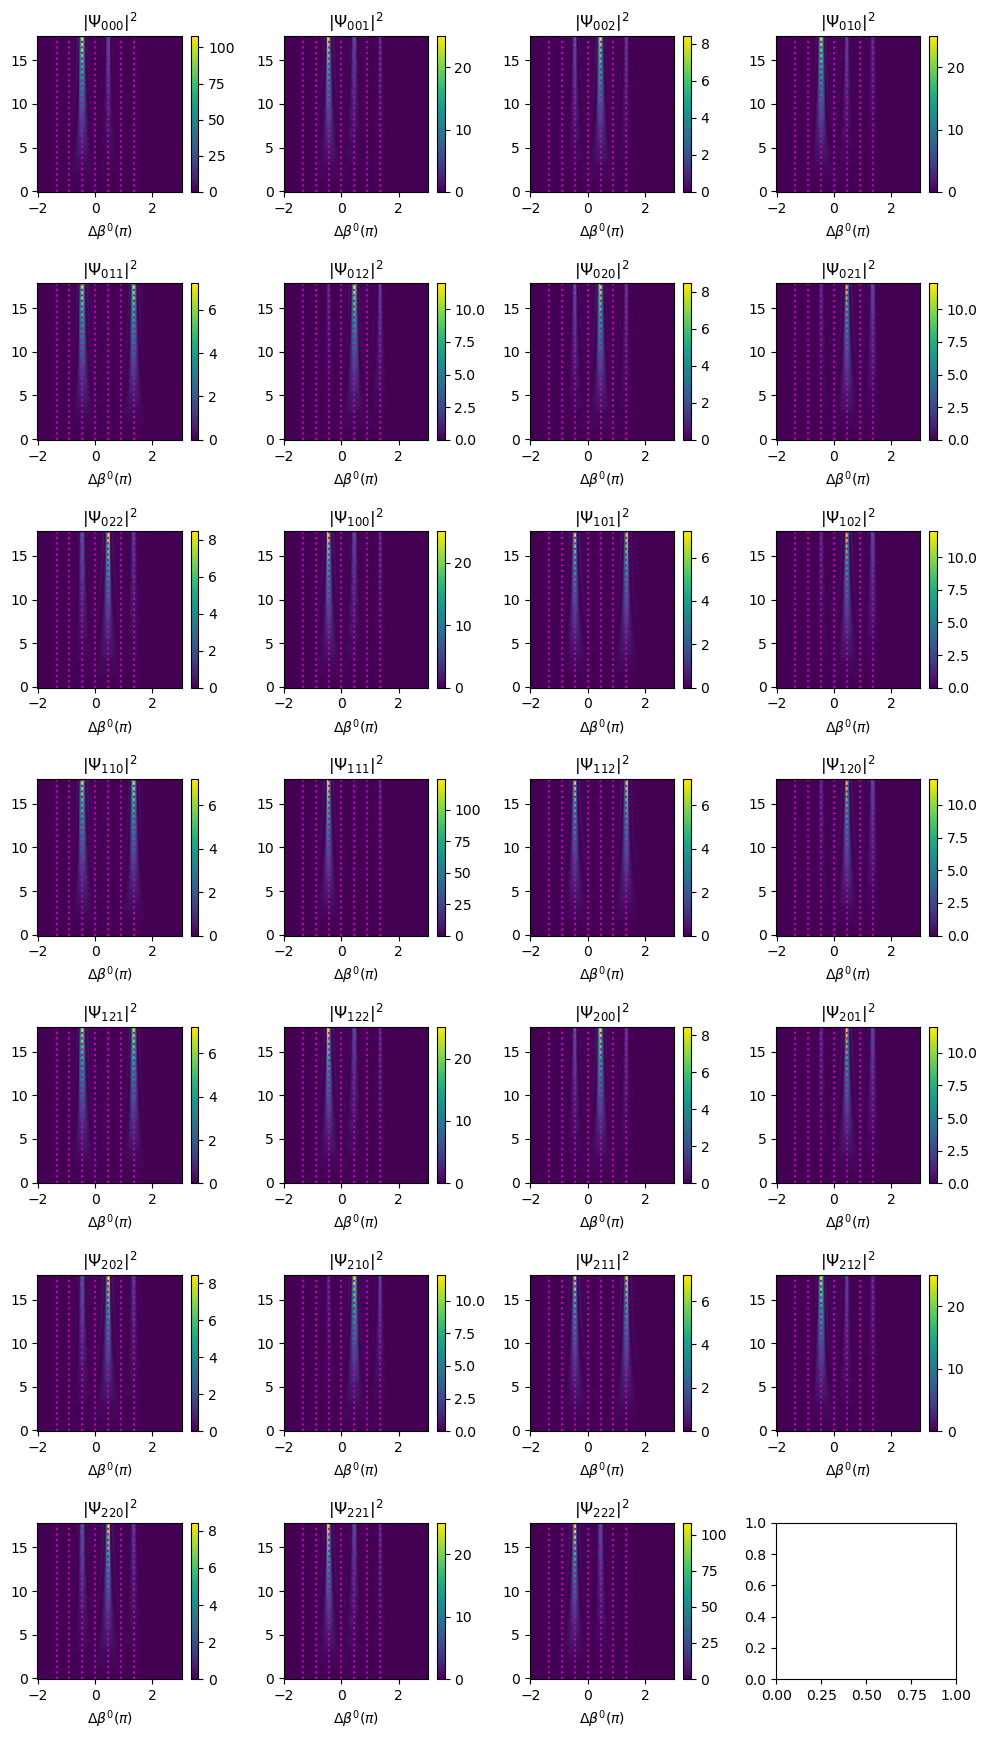

In [210]:
results_df = calc_resonances(N_waveguides=3,N_photons=3,C_vals=[1,1,1])
resonances = np.array(list(set(results_df['Resonance'])))/np.pi
plot_all_wfcn(main_df,resonances,Psi_index_n3,Psi_index_plot_n3)

## Workspace 6 - Analytic N Waveguides

### Model

In [20]:
from scipy.integrate import quad

N_waveguides = 3
n_photon = 3
state='111'


# Ap = [1*np.exp(1j*phi1), 1*np.exp(1j*phi2), 1*np.exp(1j*phi3)]
C_vals = [1,1,1]


def wfcn(z,state,delBeta0,C_vals,Ap,N_waveguides):

    # Inverse Discrete Fourier Transform to calculate wavefunction in real space
    wfcn_lmn=0

    for i in range(N_waveguides):
        for j in range(N_waveguides):
            for k in range(N_waveguides):
                # Loop to calculate wavefunction in k-space

                kx = (i+1)*np.pi/(N_waveguides+1)
                ky = (j+1)*np.pi/(N_waveguides+1)
                kz = (k+1)*np.pi/(N_waveguides+1)

                # Three-photon spatial index
                l,m,n = map(int,state)

                # Summation over the pump waveguides
                gamma_k = sum([Ap[index] * (2/(N_waveguides+1))**(3/2) * np.sin(kx*(index+1))
                            * np.sin(ky*(index+1)) * np.sin(kz*(index+1)) for index in range(N_waveguides)]) 
                
                # Calculate overall phase-mismatch
                delbeta_C = 2*C_vals[0]*np.cos(kx) + 2*C_vals[1]*np.cos(ky) + 2*C_vals[2]*np.cos(kz)
                delbeta_k = delBeta0-delbeta_C

                if delbeta_k == 0:
                    wfcn_k = z*gamma_k*np.exp(1j*delbeta_C*z)

                else:
                    # Calculate integral over z
                    integral = quad(lambda x: np.exp(1j*(delbeta_k)*x), 0, z,  complex_func=True)[0]

                    # Calculate wavefunction in k-space
                    wfcn_k = np.exp(1j*delbeta_C*z)*gamma_k*integral

                wfcn_lmn += wfcn_k * (2/(N_waveguides+1))**(3/2) * np.sin(kx*l) * np.sin(ky*m) * np.sin(kz*n)

    amp = np.abs(wfcn_lmn)**2
    
    return amp

### Results

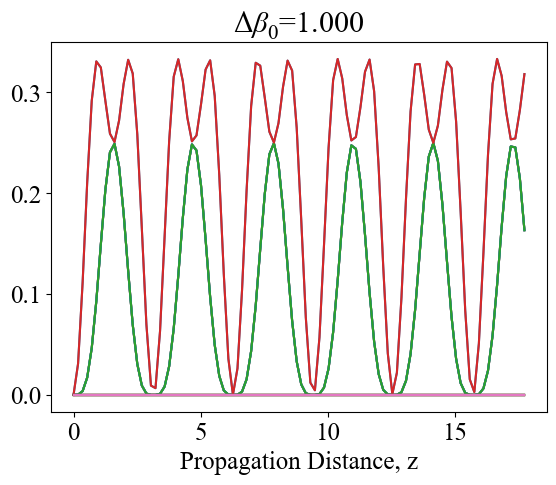

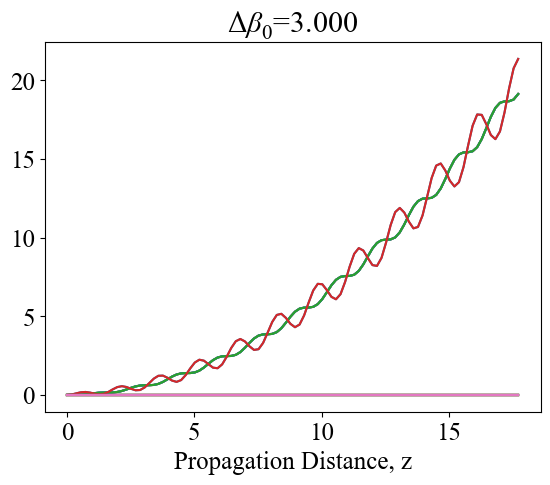

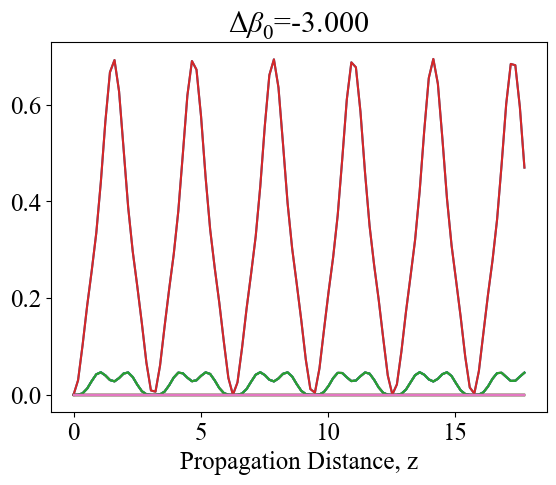

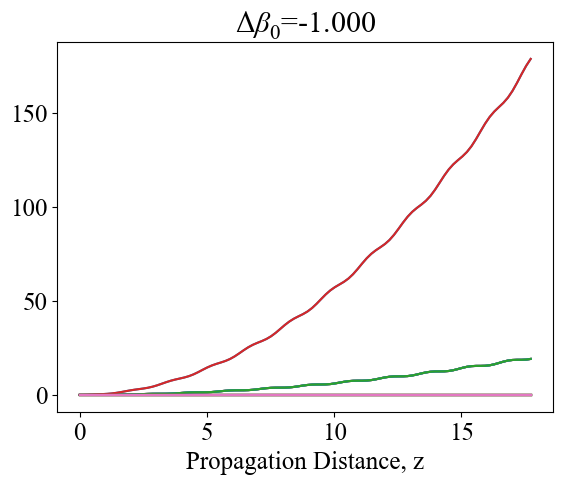

In [117]:
# Spatial propagation - For comparison with numeriical results

z_range=np.linspace(0,17.7317,100)
C_vals = [1,1,1]
Ap =  [1+0j, 1+0j, 1+0j]

results_df = calc_resonances(N_waveguides=2,N_photons=3,C_vals=C_vals)
resonancels = list(set(results_df['Resonance']))
resonancels

for delBeta in resonancels:
    for state in states:
        solution = []
        for z in z_range:
            solution.append(wfcn(z,state,delBeta,C_vals,Ap,N_waveguides=2))
        plt.title(r'$\Delta \beta_0$=%0.3f' %(delBeta))
        plt.plot(z_range,solution)
        plt.xlabel('Propagation Distance, z')
    plt.show()

In [ ]:
17.7317/(4)

4.432925

In [124]:
14/np.pi

4.45633840657307

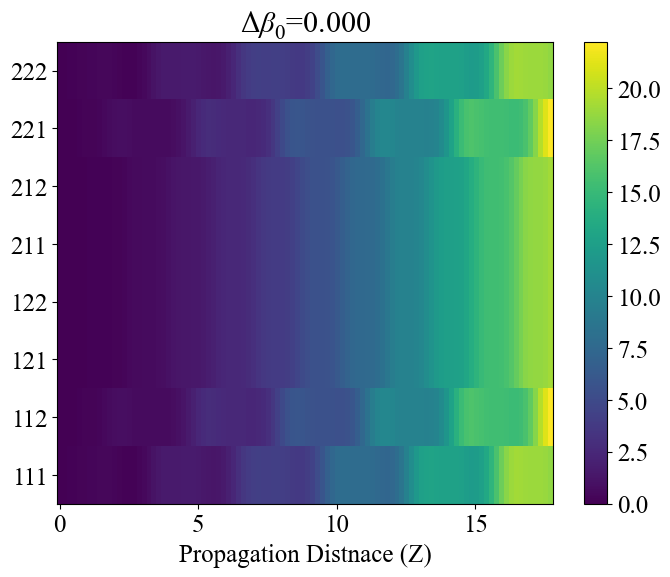

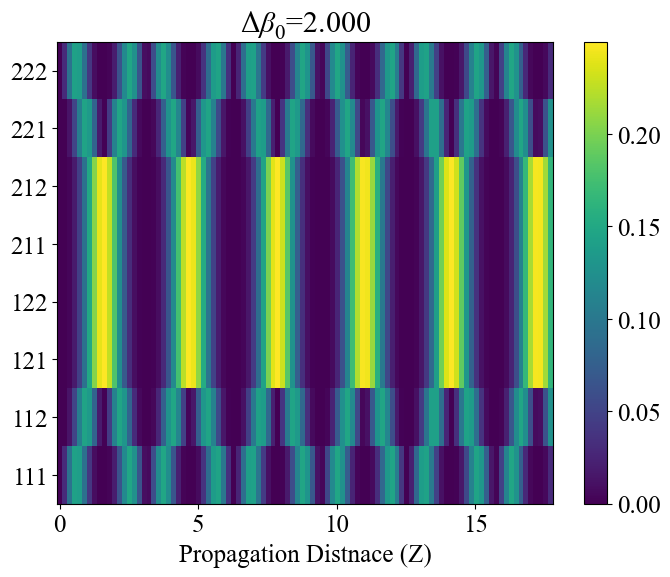

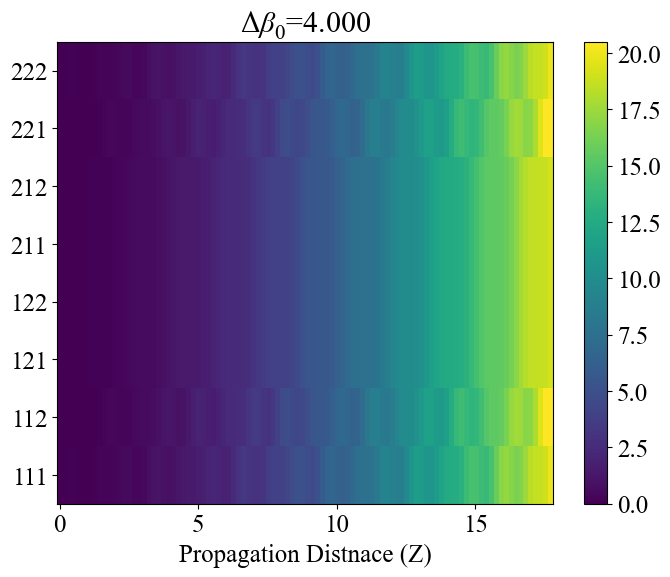

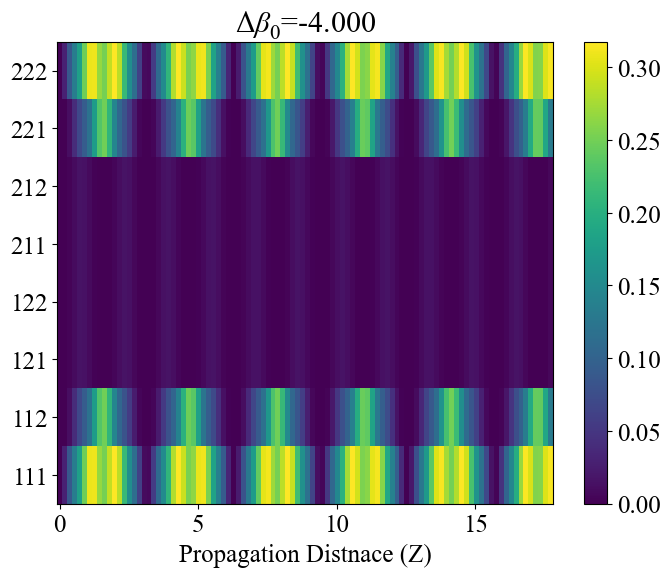

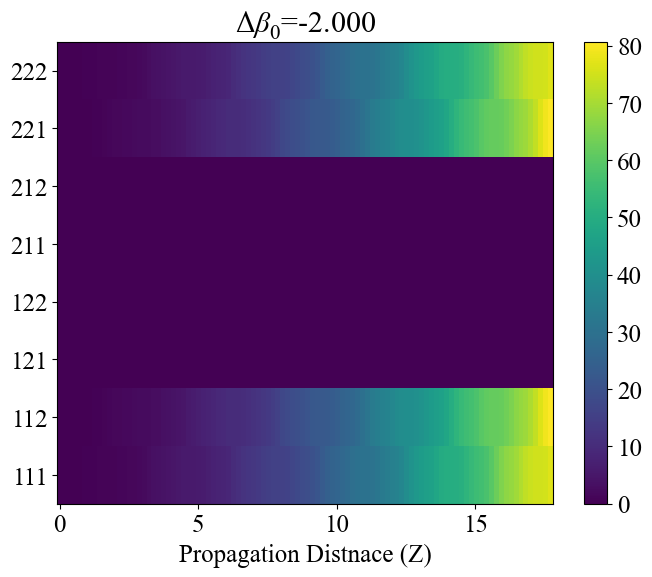

In [ ]:
# Parameter tuning routine - Spatial propagation - N=2 

C_vals = [1,1,2]
Ap =  [1+0j, 1+0j, 1+0j]

states = generate_states(N_waveguides=2,N_photons=3)
results_df = calc_resonances(N_waveguides=2,N_photons=3,C_vals=[1,1,2])
resonancels = list(set(results_df['Resonance']))
resonancels

for delBeta in resonancels:
    solution_per_param = []
    z_range = np.linspace(0,17.7317,100)
    for z in z_range:
        solution_per_state = []
        for state in states:
            solution_per_state.append(wfcn(z,state,delBeta,C_vals,Ap,2))
        
        solution_per_param.append(solution_per_state)

    d2_array = np.transpose(np.array(solution_per_param))

    plt.figure(figsize=(8,6))
    plt.title(r'$\Delta \beta_0$=%0.3f' %(delBeta))
    #plt.imshow(d2_array,aspect=2)
    plt.pcolormesh(z_range,range(len(states)),d2_array)
    plt.yticks(range(len(states)), states)
    #plt.xticks([0,10,20,30,40,50],labels=['0','1','2','3','4','5'])
    plt.xlabel('Propagation Distnace (Z)')
    plt.colorbar()
    plt.show()

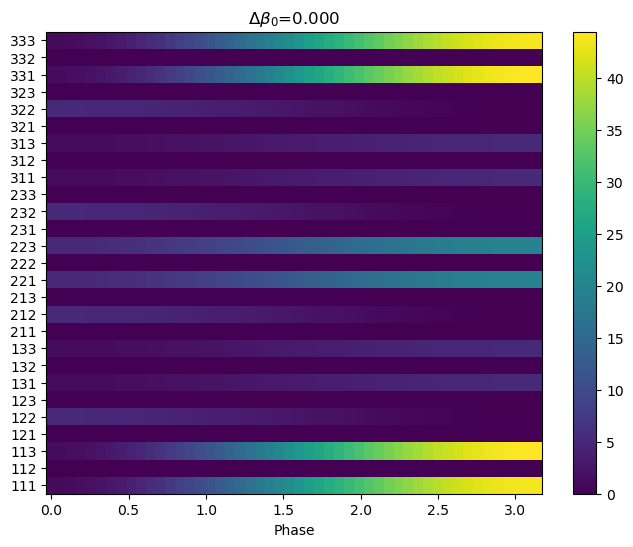

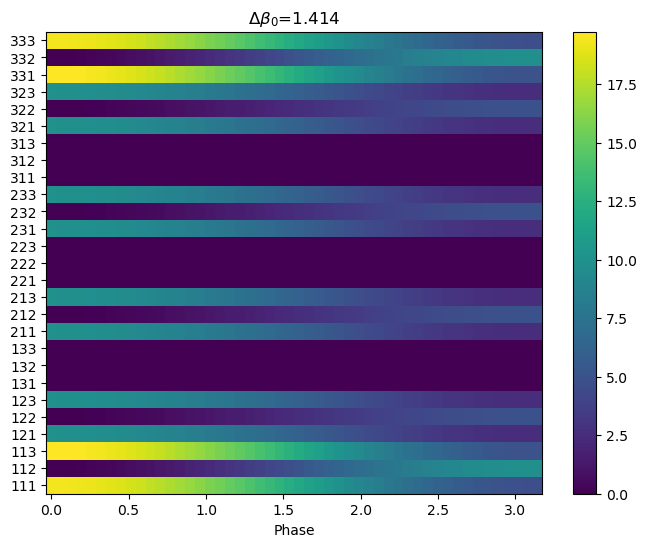

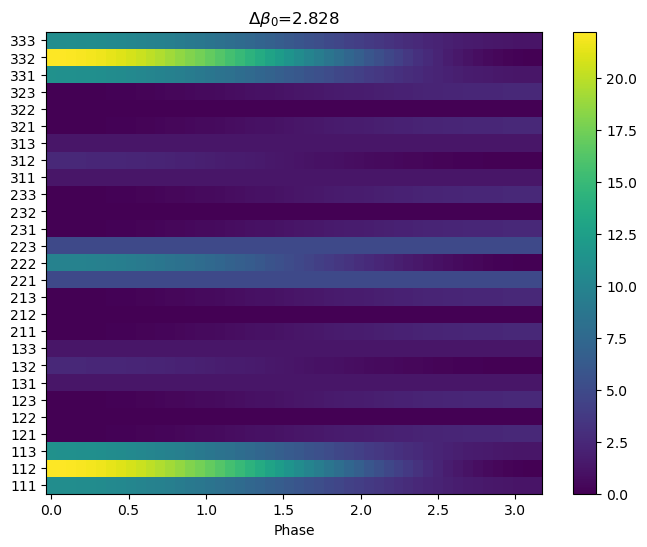

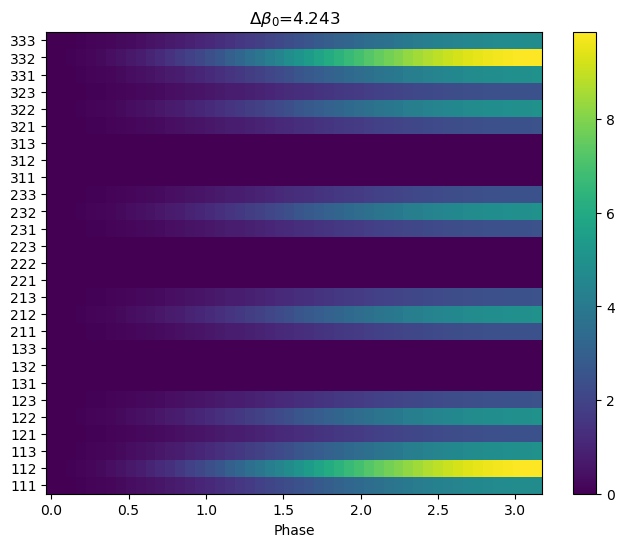

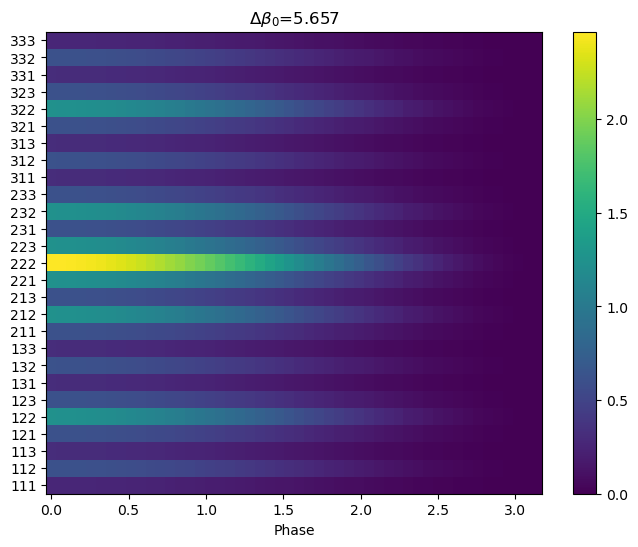

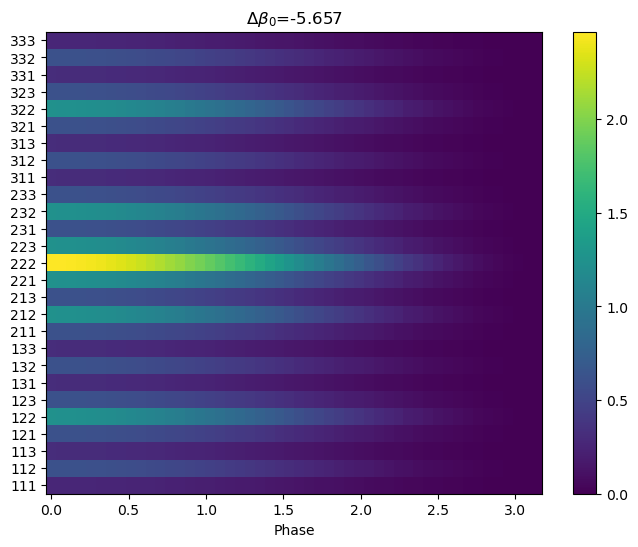

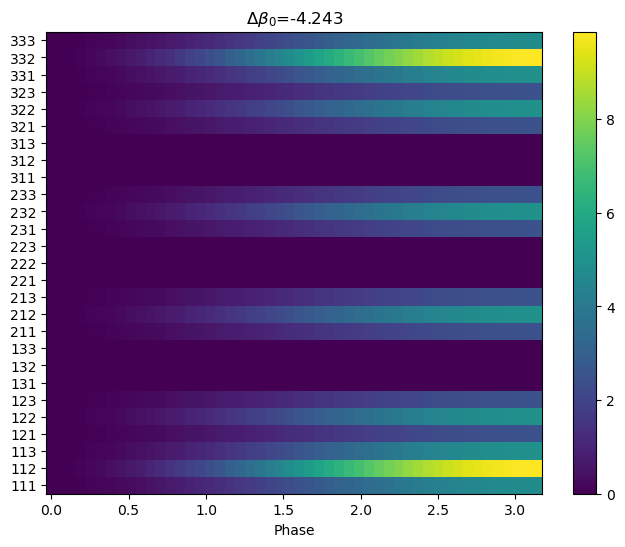

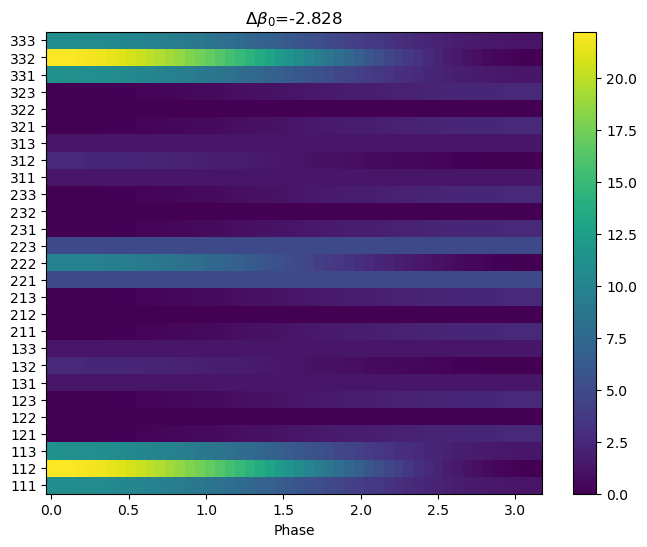

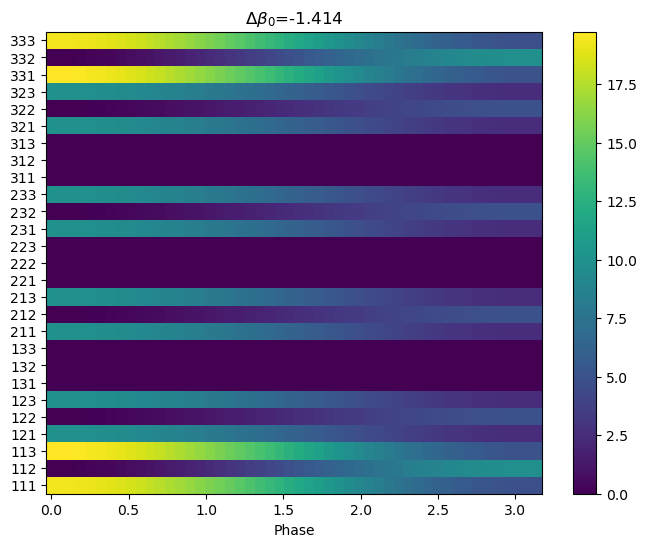

In [55]:
# Parameter tuning routine - Fixed z, vary parameter

C_vals = [1,1,2]
Ap =  [1+0j, 1+0j, 1+0j]
N_waveguides = 3
N_photons = 3

states = generate_states(N_waveguides,N_photons)
results_df = calc_resonances(N_waveguides,N_photons,C_vals)
resonancels = list(set(results_df['Resonance']))
resonancels

for delBeta in resonancels:
    solution_per_param = []
    #z_range = np.linspace(0,17.7317,100)
    phase_range = np.linspace(0,np.pi,50)
    for phase in phase_range:
        solution_per_state = []
        for state in states:
            Ap =  [1, 0, 1*np.exp(1j*phase)]
            solution_per_state.append(wfcn(17.7317,state,delBeta,C_vals,Ap,N_waveguides))
        
        solution_per_param.append(solution_per_state)

    d2_array = np.transpose(np.array(solution_per_param))

    plt.figure(figsize=(8,6))
    plt.title(r'$\Delta \beta_0$=%0.3f' %(delBeta))
    plt.pcolormesh(phase_range,range(len(states)),d2_array)
    plt.yticks(range(len(states)), states)
    plt.xlabel('Phase')
    plt.colorbar()
    plt.show()
    

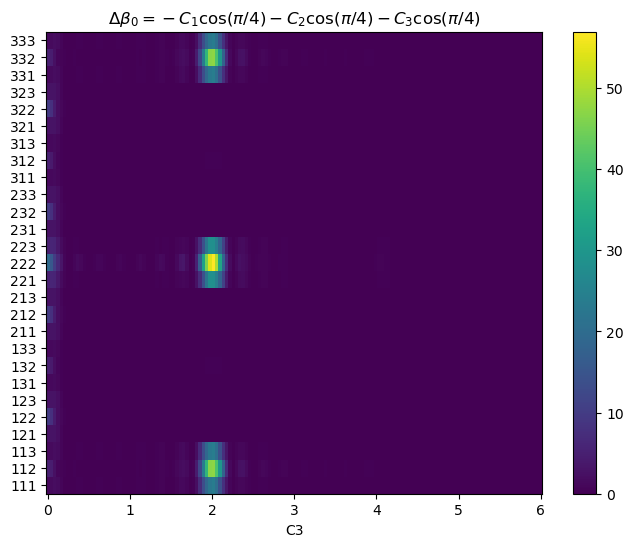

In [49]:
# Parameter tuning routine - Fixed z, vary phase

C_vals = [1,1,2]
Ap =  [1+0j, 1+0j, 1+0j]
N_waveguides = 3
N_photons = 3

states = generate_states(N_waveguides,N_photons)
results_df = calc_resonances(N_waveguides,N_photons,C_vals)
resonancels = list(set(results_df['Resonance']))
resonancels


solution_per_param = []
#z_range = np.linspace(0,17.7317,100)
C3_range = np.linspace(0,6,150)
for c3 in C3_range:
    solution_per_state = []
    for state in states:
        C_vals =  [ 1, 1, c3]
        delBeta = 1*np.cos(np.pi/4) + 1*np.cos(np.pi/4) + 2*np.cos(np.pi/4) 
        solution_per_state.append(wfcn(17.7317,state,-delBeta,C_vals,Ap,N_waveguides))
    
    solution_per_param.append(solution_per_state)

d2_array = np.transpose(np.array(solution_per_param))

plt.figure(figsize=(8,6))
plt.title(r'$\Delta \beta_0=-C_1\cos(\pi/4) - C_2\cos(\pi/4) - C_3\cos(\pi/4)$')
plt.pcolormesh(C3_range,range(len(states)),d2_array)
plt.yticks(range(len(states)), states)
plt.xlabel('C3')
plt.colorbar()
plt.show()
    

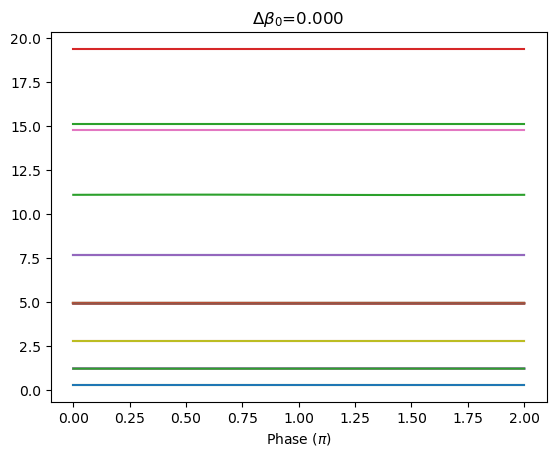

KeyboardInterrupt: 

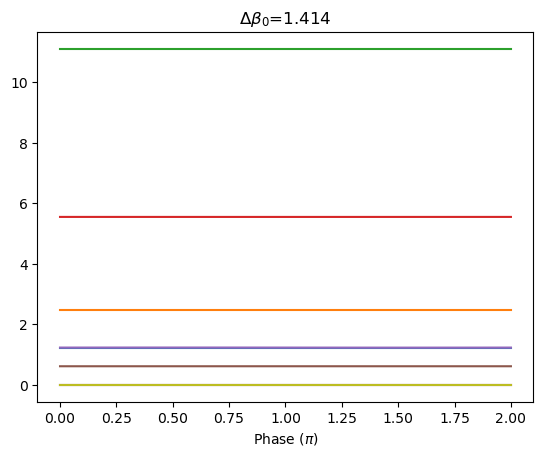

In [53]:
# Phase propagation at fixed Z

phi_range=np.linspace(0,2*np.pi,100)
C_vals = [1,1,2]

states = generate_states(N_waveguides=3,N_photons=3)
results_df = calc_resonances(N_waveguides=3,N_photons=3,C_vals=C_vals)
resonancels = list(set(results_df['Resonance']))
resonancels

for delBeta in resonancels:
    for state in states:
        solution = []
        for phi in phi_range:
            Ap =  [0, 1, 1*np.exp(1j*phi)]
            solution.append(wfcn(17.7317,state,delBeta,C_vals,Ap,N_waveguides=3))
        plt.title(r'$\Delta \beta_0$=%0.3f' %(delBeta))
        plt.plot(phi_range/np.pi,solution)
        plt.xlabel(r'Phase ($\pi$)')
    plt.show()

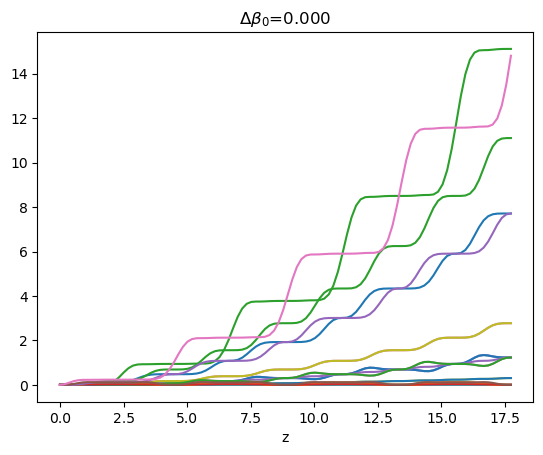

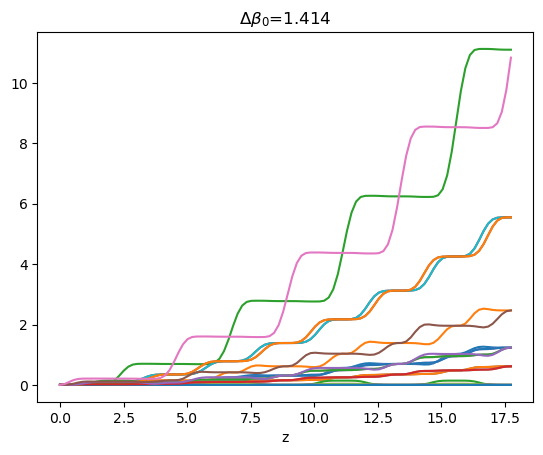

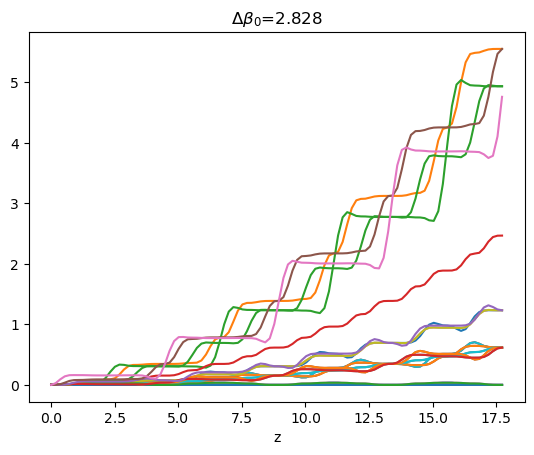

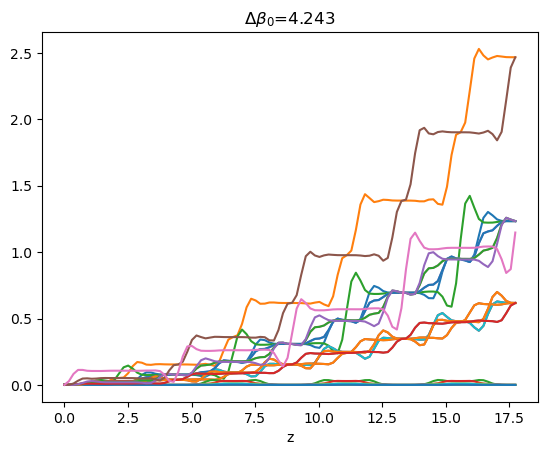

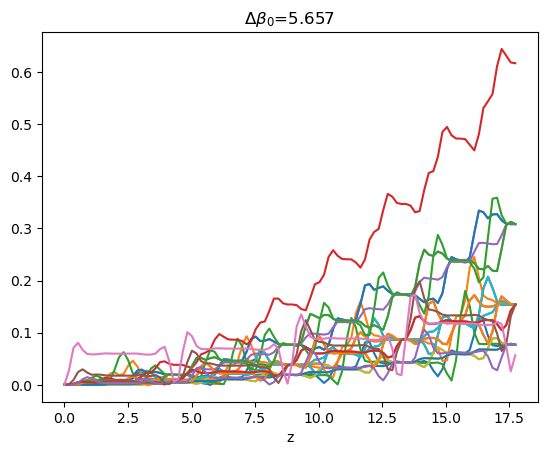

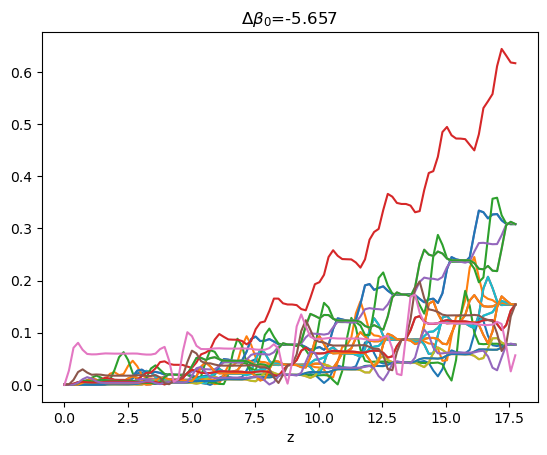

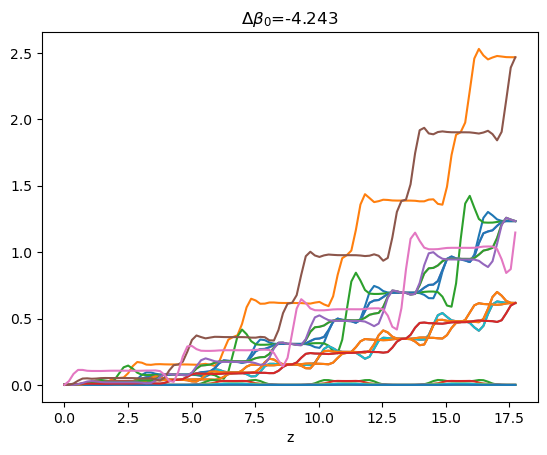

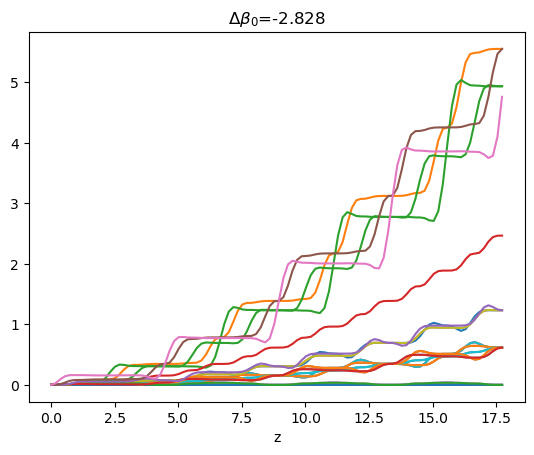

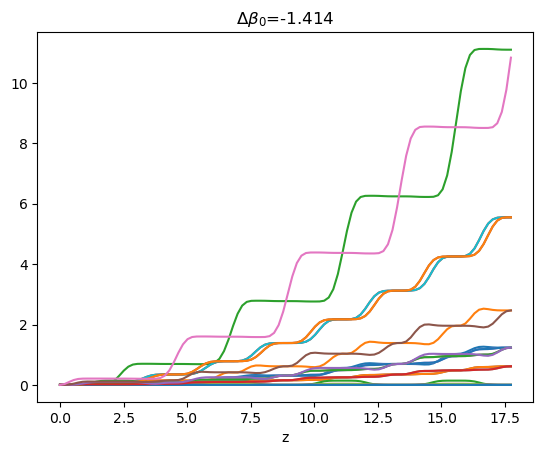

In [ ]:
# Phase propagation at fixed Z

z_range=np.linspace(0,17.7317,100)
C_vals = [1,1,2]

states = generate_states(N_waveguides=3,N_photons=3)
results_df = calc_resonances(N_waveguides=3,N_photons=3,C_vals=C_vals)
resonancels = list(set(results_df['Resonance']))
resonancels

for delBeta in resonancels:
    for state in states:
        solution = []
        for z in z_range:
             Ap =  [0, 1, 1*np.exp(1j*phi)]
            solution.append(wfcn(z,state,delBeta,C_vals,Ap,N_waveguides=3))
        plt.title(r'$\Delta \beta_0$=%0.3f' %(delBeta))
        plt.plot(z_range,solution)
        plt.xlabel(r'z')
    plt.show()

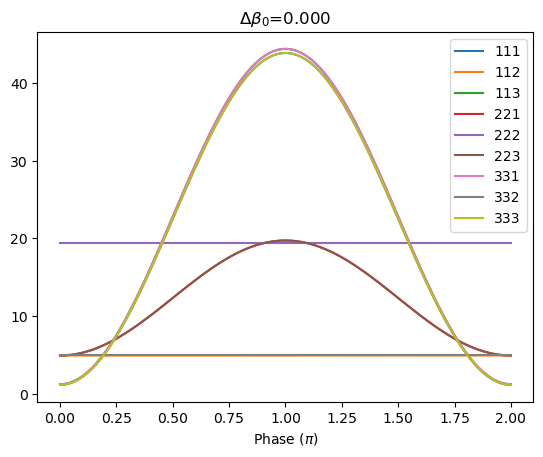

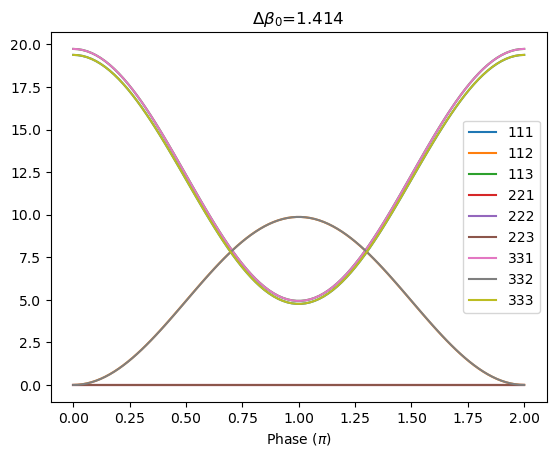

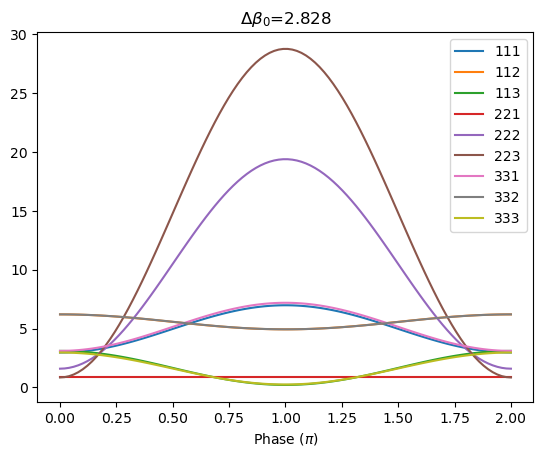

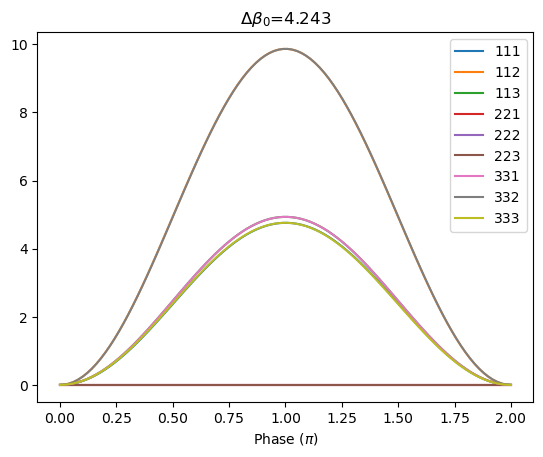

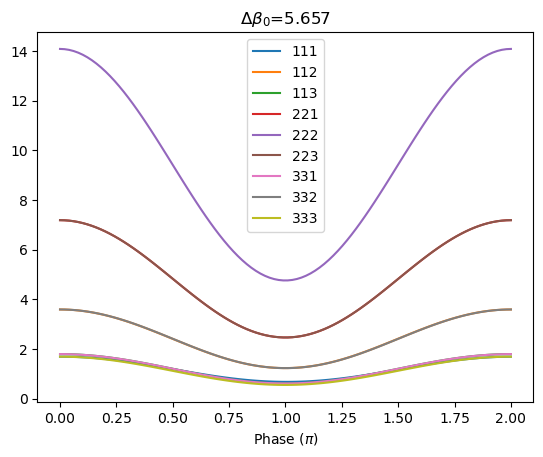

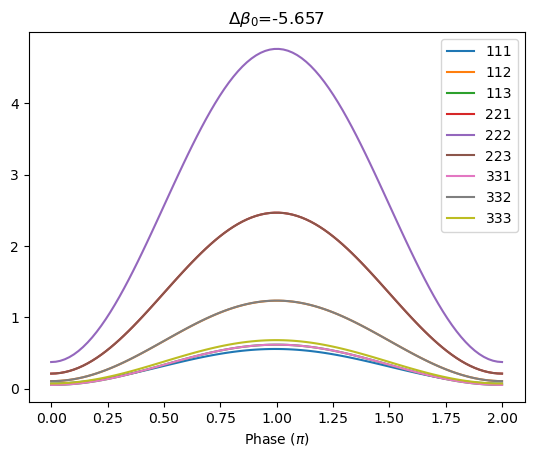

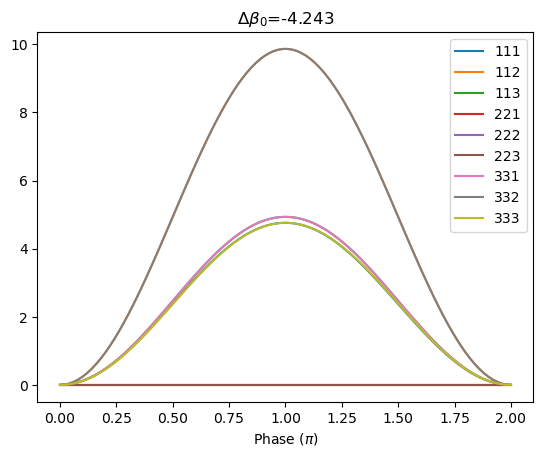

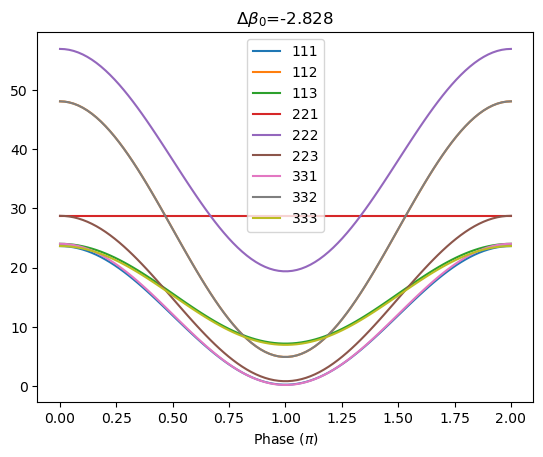

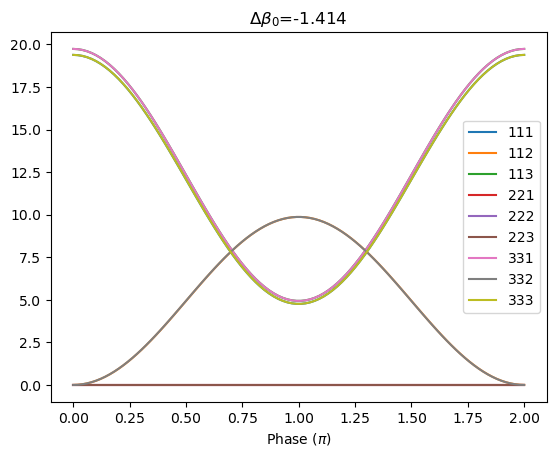

In [34]:
# Phase propagation at fixed Z

phi_range=np.linspace(0,2*np.pi,100)
C_vals = [1,1,2]

states = ['111','112','113',
          '221','222','223',
          '331','332','333']
results_df = calc_resonances(N_waveguides=3,N_photons=3,C_vals=C_vals)
resonancels = list(set(results_df['Resonance']))
resonancels

for delBeta in resonancels:
    for state in states:
        solution = []
        for phi in phi_range:
            Ap =  [1*np.exp(1j*phi), 1, 1]
            solution.append(wfcn(17.7317,state,delBeta,C_vals,Ap,N_waveguides=3))
        plt.title(r'$\Delta \beta_0$=%0.3f' %(delBeta))
        plt.plot(phi_range/np.pi,solution,label=state)
        plt.xlabel(r'Phase ($\pi$)')
    plt.legend()
    plt.show()

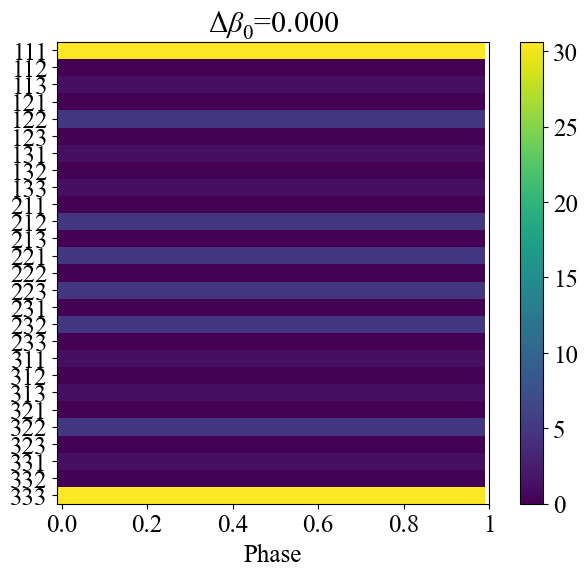

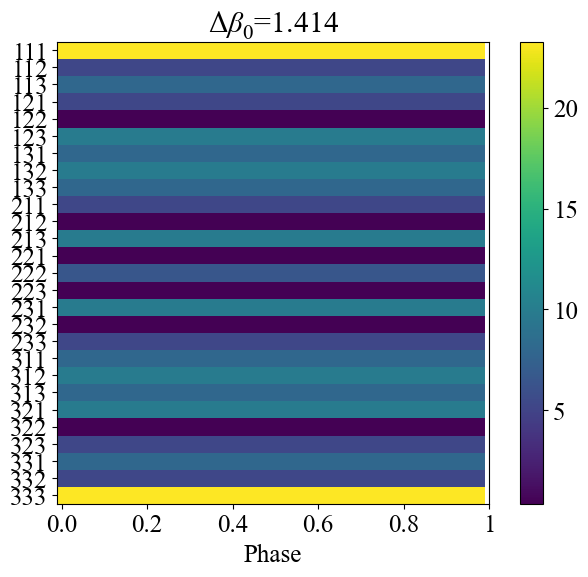

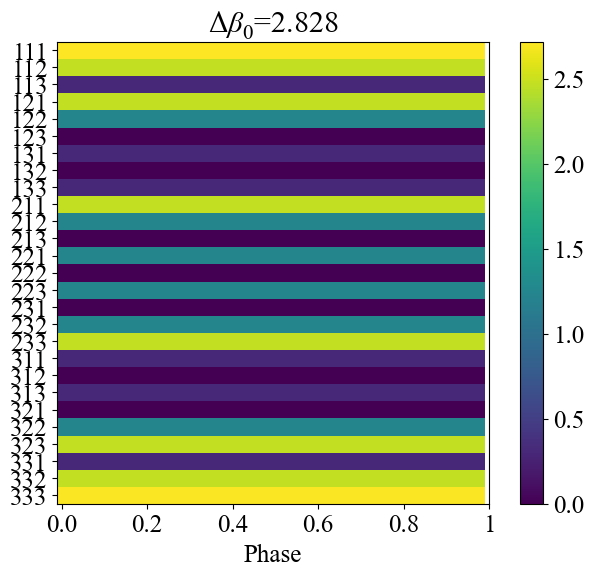

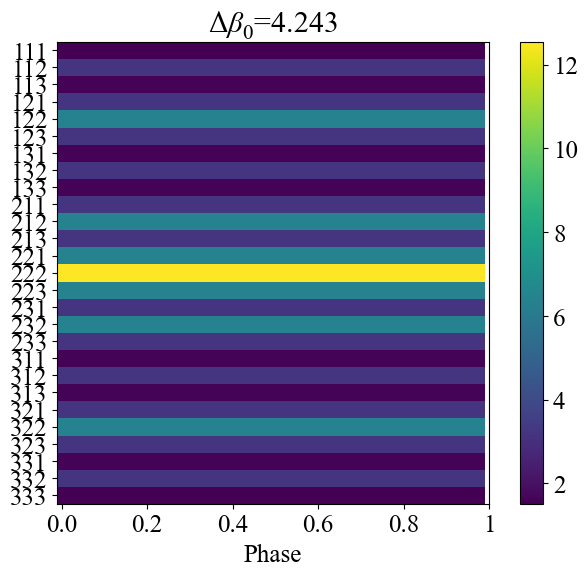

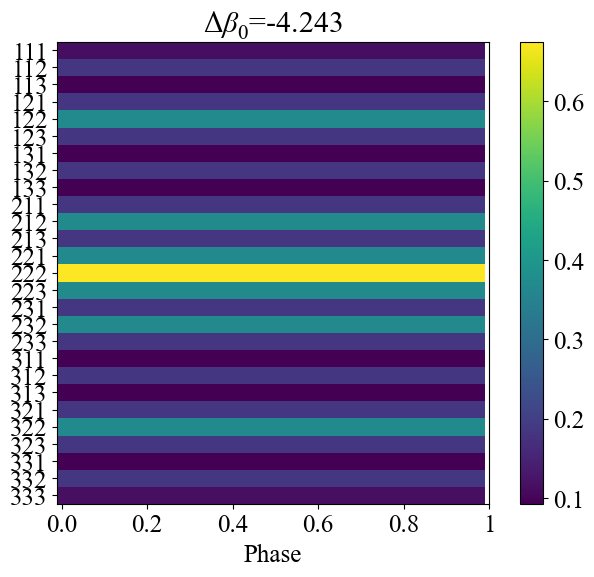

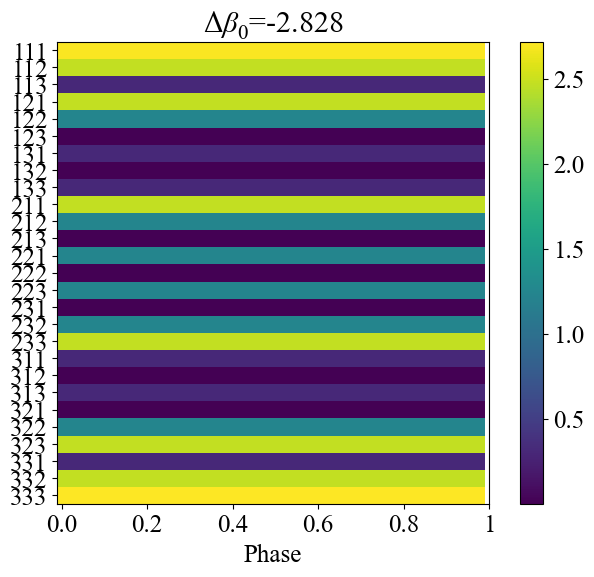

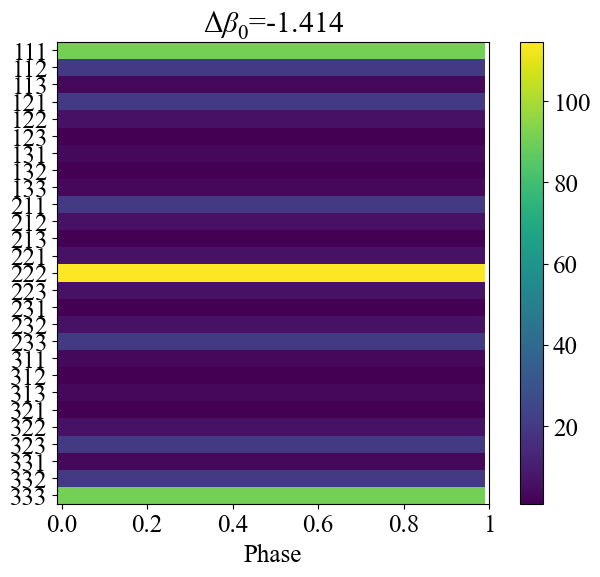

In [ ]:
# Parameter tuning routine -  Pump at Waveguide 1,3 and vary the phase

C_vals = [1,1,1]
Ap =  [1+0j, 1+0j, 1+0j]

results_df = calc_resonances(N_waveguides=3,N_photons=3,C_vals=[1,1,1])
resonancels = list(set(results_df['Resonance']))
resonancels


for delBeta in resonancels:
    solution_per_param = []
    for phase in np.linspace(0,np.pi/2,50):
        angles = phase + np.array([0, np.pi/6, 2*np.pi/6])
        Ap = np.exp(1j * angles)
        #Ap = [1+j*phase, 1+1j*phase+0.5j , 1+1j*phase+1j]
        # C_vals = [1,1,C3]

        solution_per_state = []
        for state in states:
            solution_per_state.append(wfcn(17.7317,state,delBeta,C_vals,Ap))
        
        solution_per_param.append(solution_per_state)

    d2_array = np.transpose(np.array(solution_per_param))

    plt.figure(figsize=(8,6))
    plt.title(r'$\Delta \beta_0$=%0.3f' %(delBeta))
    plt.imshow(d2_array,aspect=2)
    plt.yticks(range(len(states)), states)
    plt.xticks([0,10,20,30,40,50],labels=['0.0','0.2','0.4','0.6','0.8','1'])
    plt.xlabel('Phase')
    plt.colorbar()
    plt.show()

## Workspace 7 - Analytic Optimization

In [29]:
states = generate_states(3,3)

In [30]:
states

['111',
 '112',
 '113',
 '121',
 '122',
 '123',
 '131',
 '132',
 '133',
 '211',
 '212',
 '213',
 '221',
 '222',
 '223',
 '231',
 '232',
 '233',
 '311',
 '312',
 '313',
 '321',
 '322',
 '323',
 '331',
 '332',
 '333']

### Goal 1: Heralded Bell State

$$ |\psi\rangle = |111\rangle + |112\rangle + |113\rangle + |221\rangle + |222\rangle + |223\rangle + |331\rangle + |332\rangle + |333\rangle $$

#### Pump phase engineering

In [ ]:
from scipy.optimize import leastsq,least_squares,curve_fit
from scipy.integrate import quad

N_waveguides = 3
n_photon = 3
state='111'
z=17.7317

C_vals = [1,1,1]

def wfcn_v2(state,phi1,phi2,phi3):
    z=17.7317
    N_waveguides = 3
    delBeta0 = -2.828
    C_vals = [1,1,2]

    Ap = [1*np.exp(1j*phi1),1*np.exp(1j*phi2),1*np.exp(1j*phi3)]

    amps = []
    for state in states:

        # Inverse Discrete Fourier Transform to calculate wavefunction in real space
        wfcn_lmn=0

        for i in range(N_waveguides):
            for j in range(N_waveguides):
                for k in range(N_waveguides):
                    # Loop to calculate wavefunction in k-space

                    kx = (i+1)*np.pi/(N_waveguides+1)
                    ky = (j+1)*np.pi/(N_waveguides+1)
                    kz = (k+1)*np.pi/(N_waveguides+1)

                    # Three-photon spatial index
                    l,m,n = map(int,state)

                    # Summation over the pump waveguides
                    gamma_k = sum([Ap[index] * (2/(N_waveguides+1))**(3/2) * np.sin(kx*(index+1))
                                * np.sin(ky*(index+1)) * np.sin(kz*(index+1)) for index in range(N_waveguides)]) 
                    
                    # Calculate overall phase-mismatch
                    delbeta_C = 2*C_vals[0]*np.cos(kx) + 2*C_vals[1]*np.cos(ky) + 2*C_vals[2]*np.cos(kz)
                    delbeta_k = delBeta0-delbeta_C

                    if delbeta_k == 0:
                        wfcn_k = z*gamma_k*np.exp(1j*delbeta_C*z)

                    else:
                        # Calculate integral over z
                        integral = quad(lambda x: np.exp(1j*(delbeta_k)*x), 0, z,  complex_func=True)[0]

                        # Calculate wavefunction in k-space
                        wfcn_k = np.exp(1j*delbeta_C*z)*gamma_k*integral

                    wfcn_lmn += wfcn_k * (2/(N_waveguides+1))**(3/2) * np.sin(kx*l) * np.sin(ky*m) * np.sin(kz*n)

        amps.append(np.abs(wfcn_lmn)**2)
    
    norm = sum(amps)
    return np.array([x/norm for x in amps])



In [ ]:
# Using least_squares

HBS_state_ideal = [0.11,0.11,0.11,0,0,0,0,0,0,0,0,0,0.11,0.11,0.11,0,0,0,0,0,0,0,0,0,0.11,0.11,0.11]

errfunc = lambda p,x,y: np.abs(wfcn_v2(x,*p)-y)
params = [0, 0, 0]
#optim, pcov,infodict,mesg,ier = least_squares(errfunc, params[:], args=(states, HBS_state_ideal),bounds=(0,np.pi))
results1=least_squares(errfunc, params[:], args=(states, HBS_state_ideal),bounds=(-np.pi,np.pi),ftol=1e-12 ,max_nfev=10000)

In [163]:
# Using curve_fit

HBS_state_ideal = [0.11,0.11,0.11,0,0,0,0,0,0,0,0,0,0.11,0.11,0.11,0,0,0,0,0,0,0,0,0,0.11,0.11,0.11]

errfunc = lambda p,x,y: np.abs(wfcn_v2(x,*p)-y)
params = [0, 0, 0]
#optim, pcov,infodict,mesg,ier = least_squares(errfunc, params[:], args=(states, HBS_state_ideal),bounds=(0,np.pi))
results2=curve_fit(wfcn_v2, states, HBS_state_ideal,bounds=(-np.pi,np.pi))

[-0.43238595  0.57349451 -0.43238573]
[-0.43238595  0.57349451 -0.43238573]


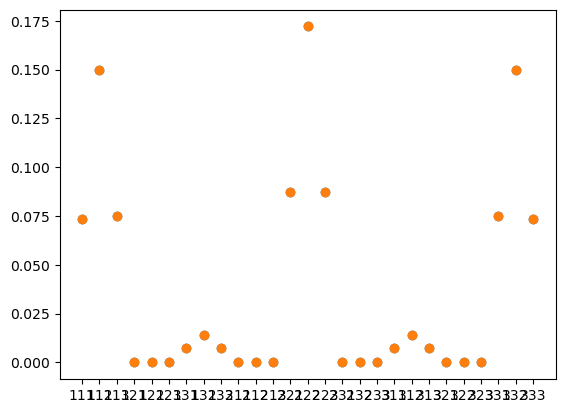

In [ ]:
optim1 = results1.x
optim2 = results2[0]
print(optim1)
print(optim2)

plt.scatter(states,wfcn_v2(states,*optim1))
plt.scatter(states,wfcn_v2(states,*optim2))
#plt.plot(wfcn_v2(states,optim[0],optim[1]/(np.pi),optim[2]/(np.pi),optim[3]/(np.pi)))
#plt.plot(wfcn_v2(states,optim[0],optim[1]/(2*np.pi),optim[2]/(2*np.pi),optim[3]/(2*np.pi)))
#plt.plot(wfcn_v2(states,optim[0],optim[1]*(np.pi),optim[2]*(np.pi),optim[3]*(np.pi)))

In [185]:
# Using global minimization: minimize
from scipy.optimize import minimize

HBS_state_ideal = [0.11,0.11,0.11,0,0,0,0,0,0,0,0,0,0.11,0.11,0.11,0,0,0,0,0,0,0,0,0,0.11,0.11,0.11]

errfunc = lambda p: sum(np.abs(wfcn_v2(states,p[0],p[1],p[2])-HBS_state_ideal))

params = [0, 0, 0]
#optim, pcov,infodict,mesg,ier = least_squares(errfunc, params[:], args=(states, HBS_state_ideal),bounds=(0,np.pi))
results4=minimize(errfunc, params, method='Nelder-Mead', bounds=[[-np.pi,np.pi],[-np.pi,np.pi],[-np.pi,np.pi]])

In [191]:
optim4 = results4.x

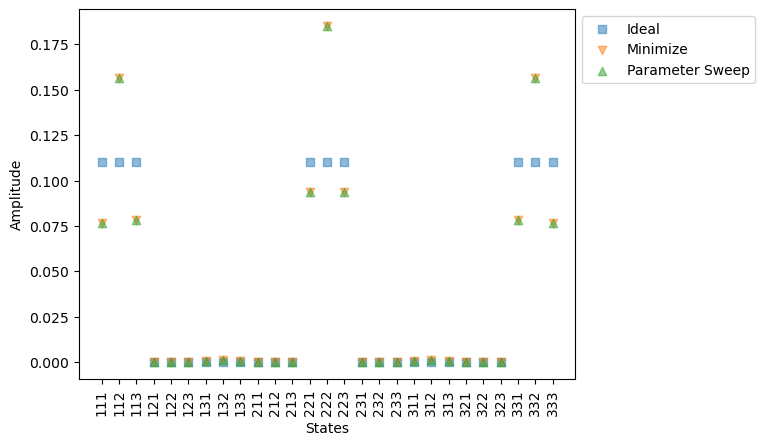

In [193]:

plt.scatter(states,HBS_state_ideal,alpha=0.5,marker='s',label='Ideal')
#plt.scatter(states,wfcn_v2(states,*optim1),alpha=0.5,marker='o',label='Fit (least_square)')
plt.scatter(states,wfcn_v2(states,*optim4),alpha=0.5,marker='v',label='Minimize')
plt.scatter(states,wfcn_v2(states,0,0,0),alpha=0.5,marker='^',label='Parameter Sweep')
plt.xticks(rotation=90)
plt.xlabel('States')
plt.ylabel('Amplitude')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [194]:
optim4

array([-0.00070345,  0.00131741, -0.00067269])

#### Pump amplitude engineering

In [195]:
from scipy.optimize import leastsq,least_squares,curve_fit
from scipy.integrate import quad

N_waveguides = 3
n_photon = 3
state='111'
z=17.7317

C_vals = [1,1,1]

def wfcn_v3(state,A1,A2,A3):
    z=17.7317
    N_waveguides = 3
    delBeta0 = -2.828
    C_vals = [1,1,2]

    Ap = [A1,A2,A3]

    amps = []
    for state in states:

        # Inverse Discrete Fourier Transform to calculate wavefunction in real space
        wfcn_lmn=0

        for i in range(N_waveguides):
            for j in range(N_waveguides):
                for k in range(N_waveguides):
                    # Loop to calculate wavefunction in k-space

                    kx = (i+1)*np.pi/(N_waveguides+1)
                    ky = (j+1)*np.pi/(N_waveguides+1)
                    kz = (k+1)*np.pi/(N_waveguides+1)

                    # Three-photon spatial index
                    l,m,n = map(int,state)

                    # Summation over the pump waveguides
                    gamma_k = sum([Ap[index] * (2/(N_waveguides+1))**(3/2) * np.sin(kx*(index+1))
                                * np.sin(ky*(index+1)) * np.sin(kz*(index+1)) for index in range(N_waveguides)]) 
                    
                    # Calculate overall phase-mismatch
                    delbeta_C = 2*C_vals[0]*np.cos(kx) + 2*C_vals[1]*np.cos(ky) + 2*C_vals[2]*np.cos(kz)
                    delbeta_k = delBeta0-delbeta_C

                    if delbeta_k == 0:
                        wfcn_k = z*gamma_k*np.exp(1j*delbeta_C*z)

                    else:
                        # Calculate integral over z
                        integral = quad(lambda x: np.exp(1j*(delbeta_k)*x), 0, z,  complex_func=True)[0]

                        # Calculate wavefunction in k-space
                        wfcn_k = np.exp(1j*delbeta_C*z)*gamma_k*integral

                    wfcn_lmn += wfcn_k * (2/(N_waveguides+1))**(3/2) * np.sin(kx*l) * np.sin(ky*m) * np.sin(kz*n)

        amps.append(np.abs(wfcn_lmn)**2)
    
    norm = sum(amps)
    return np.array([x/norm for x in amps])



In [200]:
# Using global minimization: minimize
from scipy.optimize import minimize

HBS_state_ideal = [0.11,0.11,0.11,0,0,0,0,0,0,0,0,0,0.11,0.11,0.11,0,0,0,0,0,0,0,0,0,0.11,0.11,0.11]

errfunc = lambda p: sum(np.abs(wfcn_v3(states,p[0],p[1],p[2])-HBS_state_ideal))

params = [1, 1, 1]
#optim, pcov,infodict,mesg,ier = least_squares(errfunc, params[:], args=(states, HBS_state_ideal),bounds=(0,np.pi))
results4=minimize(errfunc, params, method='Nelder-Mead', bounds=[[0,1],[0,1],[0,1]])

[1. 1. 1.]


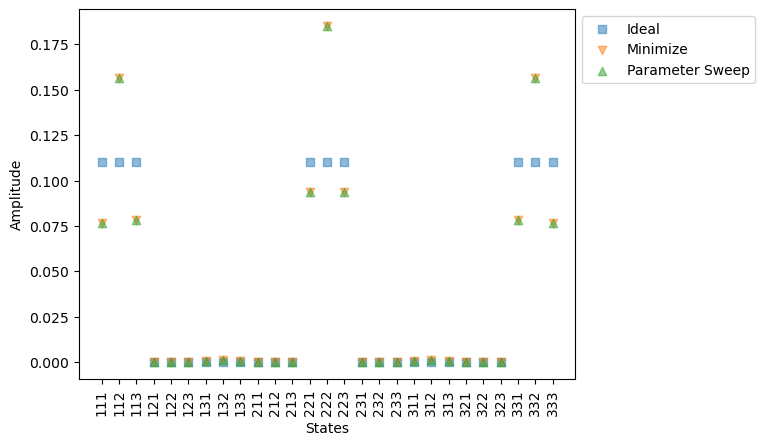

In [201]:
print(results4.x)
plt.scatter(states,HBS_state_ideal,alpha=0.5,marker='s',label='Ideal')
#plt.scatter(states,wfcn_v2(states,*optim1),alpha=0.5,marker='o',label='Fit (least_square)')
plt.scatter(states,wfcn_v3(states,*results4.x),alpha=0.5,marker='v',label='Minimize')
plt.scatter(states,wfcn_v3(states,1,1,1),alpha=0.5,marker='^',label='Parameter Sweep')
plt.xticks(rotation=90)
plt.xlabel('States')
plt.ylabel('Amplitude')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

#### Pump amplitude and phase 

In [202]:
from scipy.optimize import leastsq,least_squares,curve_fit
from scipy.integrate import quad

N_waveguides = 3
n_photon = 3
state='111'
z=17.7317

C_vals = [1,1,1]

def wfcn_v4(state,A1,A2,A3,p1,p2,p3):
    z=17.7317
    N_waveguides = 3
    delBeta0 = -2.828
    C_vals = [1,1,2]

    Ap = [A1*np.exp(1j*p1),A2*np.exp(1j*p2),A3*np.exp(1j*p3)]

    amps = []
    for state in states:

        # Inverse Discrete Fourier Transform to calculate wavefunction in real space
        wfcn_lmn=0

        for i in range(N_waveguides):
            for j in range(N_waveguides):
                for k in range(N_waveguides):
                    # Loop to calculate wavefunction in k-space

                    kx = (i+1)*np.pi/(N_waveguides+1)
                    ky = (j+1)*np.pi/(N_waveguides+1)
                    kz = (k+1)*np.pi/(N_waveguides+1)

                    # Three-photon spatial index
                    l,m,n = map(int,state)

                    # Summation over the pump waveguides
                    gamma_k = sum([Ap[index] * (2/(N_waveguides+1))**(3/2) * np.sin(kx*(index+1))
                                * np.sin(ky*(index+1)) * np.sin(kz*(index+1)) for index in range(N_waveguides)]) 
                    
                    # Calculate overall phase-mismatch
                    delbeta_C = 2*C_vals[0]*np.cos(kx) + 2*C_vals[1]*np.cos(ky) + 2*C_vals[2]*np.cos(kz)
                    delbeta_k = delBeta0-delbeta_C

                    if delbeta_k == 0:
                        wfcn_k = z*gamma_k*np.exp(1j*delbeta_C*z)

                    else:
                        # Calculate integral over z
                        integral = quad(lambda x: np.exp(1j*(delbeta_k)*x), 0, z,  complex_func=True)[0]

                        # Calculate wavefunction in k-space
                        wfcn_k = np.exp(1j*delbeta_C*z)*gamma_k*integral

                    wfcn_lmn += wfcn_k * (2/(N_waveguides+1))**(3/2) * np.sin(kx*l) * np.sin(ky*m) * np.sin(kz*n)

        amps.append(np.abs(wfcn_lmn)**2)
    
    norm = sum(amps)
    return np.array([x/norm for x in amps])



In [207]:
# Using global minimization: minimize
from scipy.optimize import minimize

HBS_state_ideal = [0.11,0.11,0.11,0,0,0,0,0,0,0,0,0,0.11,0.11,0.11,0,0,0,0,0,0,0,0,0,0.11,0.11,0.11]

errfunc = lambda p: sum(np.abs(wfcn_v4(states,p[0],p[1],p[2],p[3],p[4],p[5])-HBS_state_ideal))

params = [1, 0.5, 1,0,0,0]
#optim, pcov,infodict,mesg,ier = least_squares(errfunc, params[:], args=(states, HBS_state_ideal),bounds=(0,np.pi))
results4=minimize(errfunc, params, method='Nelder-Mead', bounds=[[0,1],[0,0.5],[0,1],[-np.pi,np.pi],[-np.pi,np.pi],[-np.pi,np.pi]])

[ 1.00000000e+00  5.00000000e-01  1.00000000e+00 -8.15931752e-04
  1.20607433e-03 -7.72032649e-04]


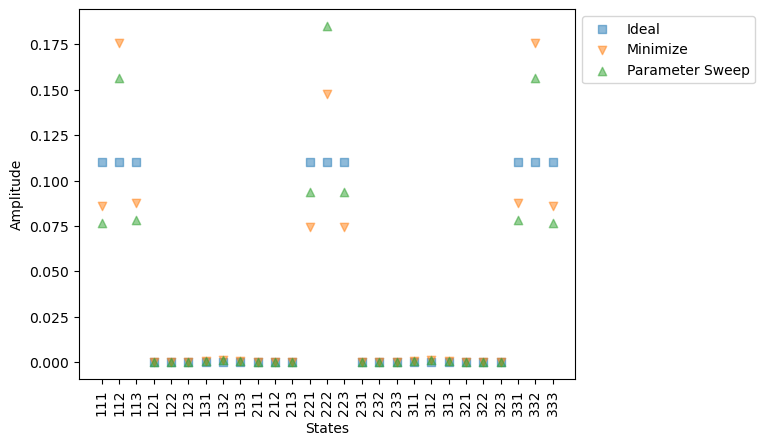

In [208]:
print(results4.x)
plt.scatter(states,HBS_state_ideal,alpha=0.5,marker='s',label='Ideal')
#plt.scatter(states,wfcn_v2(states,*optim1),alpha=0.5,marker='o',label='Fit (least_square)')
plt.scatter(states,wfcn_v4(states,*results4.x),alpha=0.5,marker='v',label='Minimize')
plt.scatter(states,wfcn_v4(states,1,1,1,0,0,0),alpha=0.5,marker='^',label='Parameter Sweep')
plt.xticks(rotation=90)
plt.xlabel('States')
plt.ylabel('Amplitude')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

#### Amplitude, phase, delBeta

In [223]:
from scipy.optimize import leastsq,least_squares,curve_fit
from scipy.integrate import quad

N_waveguides = 3
n_photon = 3
z=17.7317

C_vals = [1,1,1]

def wfcn_v5(state,delBeta0,A1,A2,A3,p1,p2,p3):
    z=17.7317
    N_waveguides = 3
    #delBeta0 = -2.828
    C_vals = [1,1,2]

    Ap = [A1*np.exp(1j*p1),A2*np.exp(1j*p2),A3*np.exp(1j*p3)]

    amps = []
    for state in states:

        # Inverse Discrete Fourier Transform to calculate wavefunction in real space
        wfcn_lmn=0

        for i in range(N_waveguides):
            for j in range(N_waveguides):
                for k in range(N_waveguides):
                    # Loop to calculate wavefunction in k-space

                    kx = (i+1)*np.pi/(N_waveguides+1)
                    ky = (j+1)*np.pi/(N_waveguides+1)
                    kz = (k+1)*np.pi/(N_waveguides+1)

                    # Three-photon spatial index
                    l,m,n = map(int,state)

                    # Summation over the pump waveguides
                    gamma_k = sum([Ap[index] * (2/(N_waveguides+1))**(3/2) * np.sin(kx*(index+1))
                                * np.sin(ky*(index+1)) * np.sin(kz*(index+1)) for index in range(N_waveguides)]) 
                    
                    # Calculate overall phase-mismatch
                    delbeta_C = 2*C_vals[0]*np.cos(kx) + 2*C_vals[1]*np.cos(ky) + 2*C_vals[2]*np.cos(kz)
                    delbeta_k = delBeta0-delbeta_C

                    if delbeta_k == 0:
                        wfcn_k = z*gamma_k*np.exp(1j*delbeta_C*z)

                    else:
                        # Calculate integral over z
                        integral = quad(lambda x: np.exp(1j*(delbeta_k)*x), 0, z,  complex_func=True)[0]

                        # Calculate wavefunction in k-space
                        wfcn_k = np.exp(1j*delbeta_C*z)*gamma_k*integral

                    wfcn_lmn += wfcn_k * (2/(N_waveguides+1))**(3/2) * np.sin(kx*l) * np.sin(ky*m) * np.sin(kz*n)

        amps.append(np.abs(wfcn_lmn)**2)
    
    norm = sum(amps)
    return np.array([x/norm for x in amps])



In [224]:
# Using global minimization: minimize
from scipy.optimize import minimize

HBS_state_ideal = [0.11,0.11,0.11,0,0,0,0,0,0,0,0,0,0.11,0.11,0.11,0,0,0,0,0,0,0,0,0,0.11,0.11,0.11]

errfunc = lambda p: sum(np.abs(wfcn_v5(states,p[0],p[1],p[2],p[3],p[4],p[5],p[6])-HBS_state_ideal))

params = [-2.828, 1, 1, 1,0,0,0]
#optim, pcov,infodict,mesg,ier = least_squares(errfunc, params[:], args=(states, HBS_state_ideal),bounds=(0,np.pi))
results4=minimize(errfunc, params, method='Nelder-Mead', bounds=[[-6,6],[0,1],[0,1],[0,1],[-np.pi,np.pi],[-np.pi,np.pi],[-np.pi,np.pi]])

[-3.03344221e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
 -1.66852387e-04  1.34948362e-04 -1.90298304e-04]


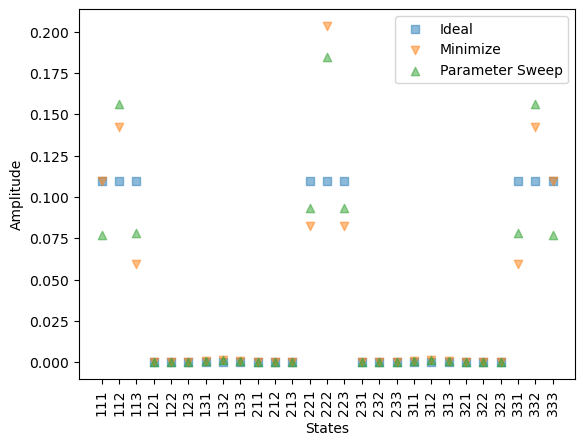

In [225]:
print(results4.x)
plt.scatter(states,HBS_state_ideal,alpha=0.5,marker='s',label='Ideal')
#plt.scatter(states,wfcn_v2(states,*optim1),alpha=0.5,marker='o',label='Fit (least_square)')
plt.scatter(states,wfcn_v5(states,*results4.x),alpha=0.5,marker='v',label='Minimize')
plt.scatter(states,wfcn_v5(states,-2.828,1,1,1,0,0,0),alpha=0.5,marker='^',label='Parameter Sweep')
plt.xticks(rotation=90)
plt.xlabel('States')
plt.ylabel('Amplitude')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

#### Amplitude, phase, delBeta, C3

In [226]:
from scipy.optimize import leastsq,least_squares,curve_fit
from scipy.integrate import quad

N_waveguides = 3
n_photon = 3
z=17.7317

C_vals = [1,1,1]

def wfcn_v6(state,C3,delBeta0,A1,A2,A3,p1,p2,p3):
    z=17.7317
    N_waveguides = 3
    #delBeta0 = -2.828
    C_vals = [1,1,C3]

    Ap = [A1*np.exp(1j*p1),A2*np.exp(1j*p2),A3*np.exp(1j*p3)]

    amps = []
    for state in states:

        # Inverse Discrete Fourier Transform to calculate wavefunction in real space
        wfcn_lmn=0

        for i in range(N_waveguides):
            for j in range(N_waveguides):
                for k in range(N_waveguides):
                    # Loop to calculate wavefunction in k-space

                    kx = (i+1)*np.pi/(N_waveguides+1)
                    ky = (j+1)*np.pi/(N_waveguides+1)
                    kz = (k+1)*np.pi/(N_waveguides+1)

                    # Three-photon spatial index
                    l,m,n = map(int,state)

                    # Summation over the pump waveguides
                    gamma_k = sum([Ap[index] * (2/(N_waveguides+1))**(3/2) * np.sin(kx*(index+1))
                                * np.sin(ky*(index+1)) * np.sin(kz*(index+1)) for index in range(N_waveguides)]) 
                    
                    # Calculate overall phase-mismatch
                    delbeta_C = 2*C_vals[0]*np.cos(kx) + 2*C_vals[1]*np.cos(ky) + 2*C_vals[2]*np.cos(kz)
                    delbeta_k = delBeta0-delbeta_C

                    if delbeta_k == 0:
                        wfcn_k = z*gamma_k*np.exp(1j*delbeta_C*z)

                    else:
                        # Calculate integral over z
                        integral = quad(lambda x: np.exp(1j*(delbeta_k)*x), 0, z,  complex_func=True)[0]

                        # Calculate wavefunction in k-space
                        wfcn_k = np.exp(1j*delbeta_C*z)*gamma_k*integral

                    wfcn_lmn += wfcn_k * (2/(N_waveguides+1))**(3/2) * np.sin(kx*l) * np.sin(ky*m) * np.sin(kz*n)

        amps.append(np.abs(wfcn_lmn)**2)
    
    norm = sum(amps)
    return np.array([x/norm for x in amps])



In [227]:
# Using global minimization: minimize
from scipy.optimize import minimize

HBS_state_ideal = [0.11,0.11,0.11,0,0,0,0,0,0,0,0,0,0.11,0.11,0.11,0,0,0,0,0,0,0,0,0,0.11,0.11,0.11]

errfunc = lambda p: sum(np.abs(wfcn_v6(states,p[0],p[1],p[2],p[3],p[4],p[5],p[6],p[7])-HBS_state_ideal))

params = [2,-2.828, 1, 1, 1,0,0,0]
#optim, pcov,infodict,mesg,ier = least_squares(errfunc, params[:], args=(states, HBS_state_ideal),bounds=(0,np.pi))
results4=minimize(errfunc, params, method='Nelder-Mead', bounds=[[0,5],[-6,6],[0,1],[0,1],[0,1],[-np.pi,np.pi],[-np.pi,np.pi],[-np.pi,np.pi]])

[ 1.87812089e+00 -3.05313551e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  2.49593555e-04 -4.83525882e-05  1.21501073e-04]


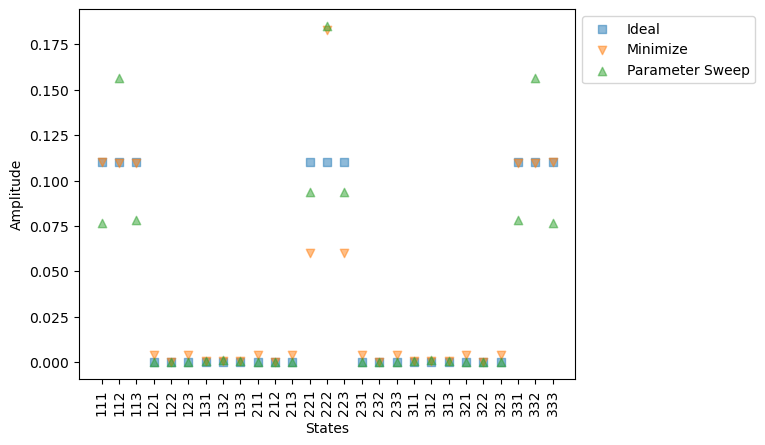

In [228]:
print(results4.x)
plt.scatter(states,HBS_state_ideal,alpha=0.5,marker='s',label='Ideal')
#plt.scatter(states,wfcn_v2(states,*optim1),alpha=0.5,marker='o',label='Fit (least_square)')
plt.scatter(states,wfcn_v6(states,*results4.x),alpha=0.5,marker='v',label='Minimize')
plt.scatter(states,wfcn_v6(states,2,-2.828,1,1,1,0,0,0),alpha=0.5,marker='^',label='Parameter Sweep')
plt.xticks(rotation=90)
plt.xlabel('States')
plt.ylabel('Amplitude')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

### Goal 2: W-State

$$ |\psi\rangle = |113\rangle + |131\rangle + |311\rangle $$

In [230]:
from scipy.optimize import leastsq,least_squares,curve_fit
from scipy.integrate import quad

N_waveguides = 3
n_photon = 3
z=17.7317

def wfcn_v7(state,delBeta0,C3,A1,A2,A3,p1,p2,p3):
    z=17.7317
    N_waveguides = 3
    #delBeta0 = -2.828
    C_vals = [C3,C3,C3]

    Ap = [A1*np.exp(1j*p1),A2*np.exp(1j*p2),A3*np.exp(1j*p3)]

    amps = []
    for state in states:

        # Inverse Discrete Fourier Transform to calculate wavefunction in real space
        wfcn_lmn=0

        for i in range(N_waveguides):
            for j in range(N_waveguides):
                for k in range(N_waveguides):
                    # Loop to calculate wavefunction in k-space

                    kx = (i+1)*np.pi/(N_waveguides+1)
                    ky = (j+1)*np.pi/(N_waveguides+1)
                    kz = (k+1)*np.pi/(N_waveguides+1)

                    # Three-photon spatial index
                    l,m,n = map(int,state)

                    # Summation over the pump waveguides
                    gamma_k = sum([Ap[index] * (2/(N_waveguides+1))**(3/2) * np.sin(kx*(index+1))
                                * np.sin(ky*(index+1)) * np.sin(kz*(index+1)) for index in range(N_waveguides)]) 
                    
                    # Calculate overall phase-mismatch
                    delbeta_C = 2*C_vals[0]*np.cos(kx) + 2*C_vals[1]*np.cos(ky) + 2*C_vals[2]*np.cos(kz)
                    delbeta_k = delBeta0-delbeta_C

                    if delbeta_k == 0:
                        wfcn_k = z*gamma_k*np.exp(1j*delbeta_C*z)

                    else:
                        # Calculate integral over z
                        integral = quad(lambda x: np.exp(1j*(delbeta_k)*x), 0, z,  complex_func=True)[0]

                        # Calculate wavefunction in k-space
                        wfcn_k = np.exp(1j*delbeta_C*z)*gamma_k*integral

                    wfcn_lmn += wfcn_k * (2/(N_waveguides+1))**(3/2) * np.sin(kx*l) * np.sin(ky*m) * np.sin(kz*n)

        amps.append(np.abs(wfcn_lmn)**2)
    
    norm = sum(amps)
    return np.array([x/norm for x in amps])



In [ ]:
# Using global minimization: minimize
from scipy.optimize import minimize
W_state_ideal = [0,0,0.33,0,0,0,0.33,0,0,0,0,0,0,0,0,0,0,0,0.33,0,0,0,0,0,0,0,0]
errfunc = lambda p: sum(np.abs(wfcn_v7(states,p[0],p[1],p[2],p[3],p[4],p[5],p[6],p[7])-W_state_ideal))

params = [1,-2.828, 1, 1, 1,0,0,0]

#optim, pcov,infodict,mesg,ier = least_squares(errfunc, params[:], args=(states, HBS_state_ideal),bounds=(0,np.pi))
results4=minimize(errfunc, params, method='Nelder-Mead', bounds=[[0,2],[-6,6],[0,1],[0,1],[0,1],[-np.pi,np.pi],[-np.pi,np.pi],[-np.pi,np.pi]])

KeyboardInterrupt: 

In [ ]:
print(results4.x)
plt.scatter(states,W_state_ideal,alpha=0.5,marker='s',label='Ideal')
#plt.scatter(states,wfcn_v2(states,*optim1),alpha=0.5,marker='o',label='Fit (least_square)')
plt.scatter(states,wfcn_v7(states,*results4.x),alpha=0.5,marker='v',label='Minimize')
plt.scatter(states,wfcn_v7(states,2,-2.828,1,1,1,0,0,0),alpha=0.5,marker='^',label='Parameter Sweep')
plt.xticks(rotation=90)
plt.xlabel('States')
plt.ylabel('Amplitude')
plt.legend(bbox_to_anchor=(1,1))
plt.show()